# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import scipy.spatial.distance
import pymorphy2

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

import warnings
warnings.filterwarnings('ignore')
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



Функционал, минимизирующий kmeans:
$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k||^2 \rightarrow\min\limits_C$$
$$ \mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n $$

На Е шаге мы присваеваем точкам кластеры. На этом шаге центроиды зафиксированы, а принадлежность точек кластерам определяется исходи из их близости к центроидам. На данном шаге функцонал не может увеличиваться.

На М шаге происходит пересчет и обновление центроидов. На этом шаге фиксированы кластеры для всех точек и уже центроиды пересчитываются, исходя из положений (расстояний) точек кластера относительно центра. На этом шаге функционал также не может увеличиться.

Получается, что данный функционал не увеличивается ни на одном шаге алгоритма.

С другой стороны можно сказать, что функционал ограничен, исходя из того, что если на некотором M шаге никакой из центроидов не обновится, то можно завершать алгоритм.

Так как каждый из N объектов мы можем отнести к одному из k кластеров, а функционал не увеличивается и ограничен, то количество итераций не будет превышать $k^{N}$. 

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



Аналогично kmeans функционал не увеличивается, а для сходимости нам немобходимо, чтобы правдоподобие системы было ограничено.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




Для начала покажем математические соотношения для min и max:

$min(A, B) = \frac{1}{2}(A + B - |A - B|)$, если A < B, то $min(A, B) = \frac{1}{2}A + \frac{1}{2}B - \frac{1}{2}B + \frac{1}{2}A  = A$, аналогично и для A >= B.

Покажем теперь для максимума:

$max(A, B) = \frac{1}{2}(A + B + |A - B|)$, если A < B, то $max(A, B) = \frac{1}{2}A + \frac{1}{2}B + \frac{1}{2}B - \frac{1}{2}A  = B$, аналогично и для A >= B.

Теперь докажем исходные формулы Ланса-Вильямса:

$$d_{\min}(U \cup V, S) = min(d_{\min}(U, S), d_{\min}(V, S)) $$ из показаных выше соотношений получаем искомое выражение. И так же max:
$$d_{\max}(U \cup V, S) = max(d_{\max}(U, S), d_{\max}(V, S)) $$

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [60]:
from sklearn.base import BaseEstimator, ClusterMixin
import scipy.cluster.hierarchy as sch

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """

    def __init__(self, n_clusters = 2, metric = 'euclidean', linkage = 'single', **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters = n_clusters
        self.__metric = metric
        if linkage == 'single':
            self.__linkage = self.__single_link
        elif linkage == 'complete':
            self.__linkage = self.__complete_link
        elif linkage == 'average':
            self.__linkage = self.__average_link
        return

    def __single_link(self, i, j, ij):
        return (0.5, 0.5, -0.5)

    def __complete_link(self, i, j, ij):
        return (0.5, 0.5, 0.5)

    def __average_link(self, i, j, ij):
        return (i.sum() / ij.sum(), j.sum() / ij.sum(), 0)
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.x_len = len(x)
        clusters = np.eye(self.x_len)

        matrix_dists = smt.pairwise_distances(x, metric=self.__metric, n_jobs=-1)
        matrix_dists[list(range(self.x_len)), list(range(self.x_len))] = np.inf
        
        res = []
        clust = [[i] for i in range(self.x_len)]
        num_clusters = self.x_len
        while num_clusters > self.n_clusters:
            arg_min = matrix_dists.argmin()
            _i, _j = arg_min // num_clusters, arg_min % num_clusters
            
            _ij = np.logical_or(clusters[_i], clusters[_j])

            a, b, c = self.__linkage(clusters[_i],
                                     clusters[_j],
                                     _ij)

            dist = (a * matrix_dists[_i] + b * matrix_dists[_j] +
                    c * np.abs(matrix_dists[_i] - matrix_dists[_j]))
            C_ij = np.nonzero(_ij)[0].tolist()
            clust.append(C_ij)
            C_i = np.nonzero(clusters[_i])[0].tolist()
            C_j = np.nonzero(clusters[_j])[0].tolist()
            res.append(np.array([clust.index(C_i), clust.index(C_j),
                      matrix_dists.min(), len(C_i) + len(C_j)], dtype=np.float64))
            matrix_dists[_i] = dist
            matrix_dists[:, _i] = dist
            matrix_dists[_i, _i] = np.inf

            matrix_dists = np.delete(np.delete(matrix_dists,
                                               _j, axis=0),
                                     _j, axis=1)

            clusters[_i] = _ij
            clusters = np.delete(clusters, _j, axis=0)
            num_clusters -= 1

        arg_min = matrix_dists.argmin()
        _i, _j = arg_min // num_clusters, arg_min % num_clusters
        _ij = np.logical_or(clusters[_i], clusters[_j])
        C_ij = np.nonzero(_ij)[0].tolist()
        clust.append(C_ij)
        C_i = np.nonzero(clusters[_i])[0].tolist()
        C_j = np.nonzero(clusters[_j])[0].tolist()
        res.append(np.array([clust.index(C_i), clust.index(C_j),
                      matrix_dists.min(), len(C_i) + len(C_j)], dtype=np.float64))
        
        self.Z = np.array(res)
        return clusters.argmax(axis=0)
    
    def plot_dendrogram(self):
        plt.figure(figsize=(20, 5))
        sch.dendrogram(self.Z)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

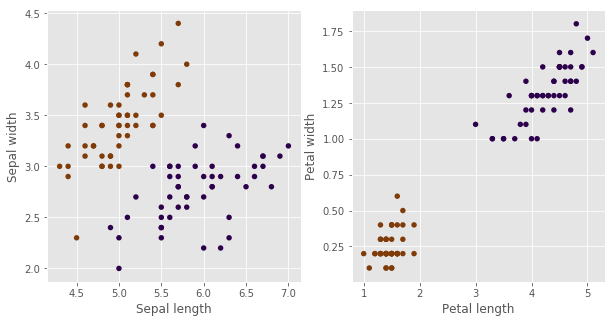

In [61]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [62]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0029366016387939453


Our AGGL score 1.0. Our AGGL time 0.029982805252075195


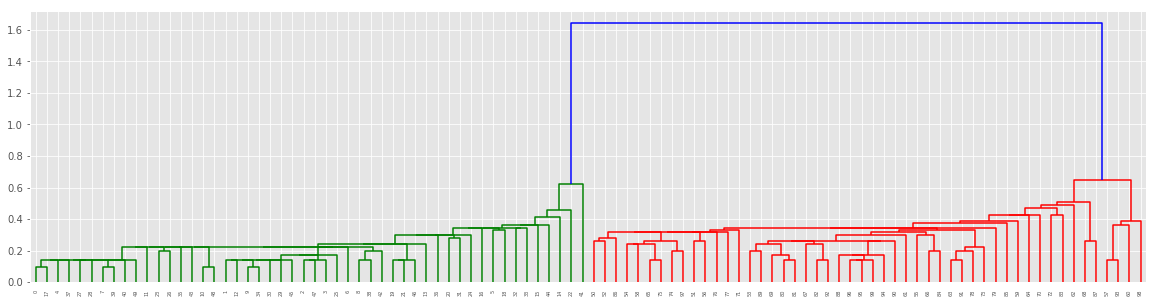

In [64]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [6]:
# нормализованные заголовки(над ними была проведена лемматизация)
norm_doc_to_title = {}
with open('norm_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        norm_doc_to_title[doc_id] = title
print(len(norm_doc_to_title))

28026


In [7]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = norm_doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [57]:
from sklearn.metrics import f1_score
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
сustum_aggl = Clustering(n_clusters=2, metric = 'cosine')
tf_idf = TfidfVectorizer()

In [18]:
model = gensim.models.KeyedVectors.load_word2vec_format('182/model.bin', binary=True)

In [11]:
morph = pymorphy2.MorphAnalyzer()
word = 'периодичный'
pos = morph.parse(word)[0].tag.POS
pos

'ADJF'

In [19]:
error = 0
def get_word_embedding(word):
    global error
    pos = morph.parse(word)[0].tag.POS
    if pos is None:
        error +=1
        return None
    elif pos == 'INFN':
        pos = 'VERB'
    elif pos.find('ADJ') != -1:
        pos = 'ADJ'
    norm_word = word + '_' + pos
    try:
        vec = model[norm_word]
        return vec
    except KeyError:
        error += 1
        return None

0.44666351798124293


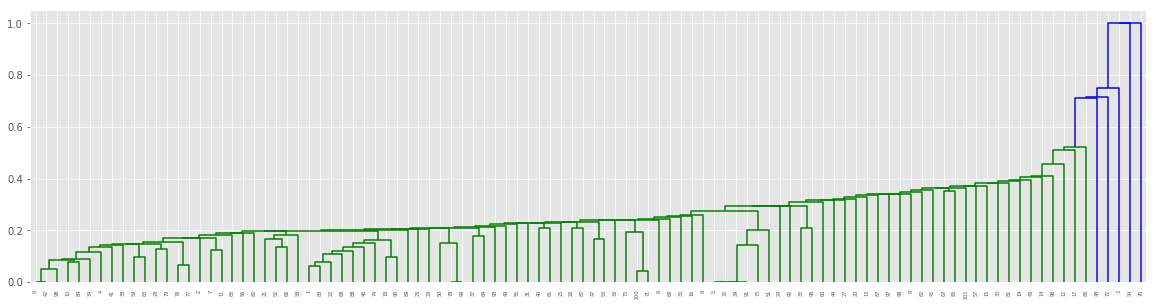

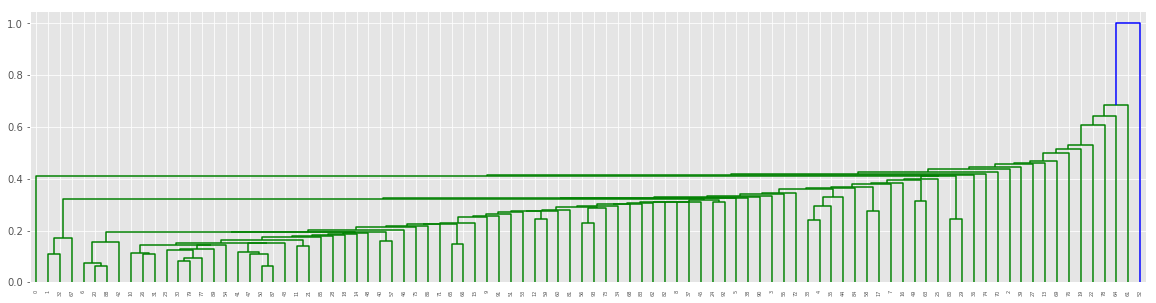

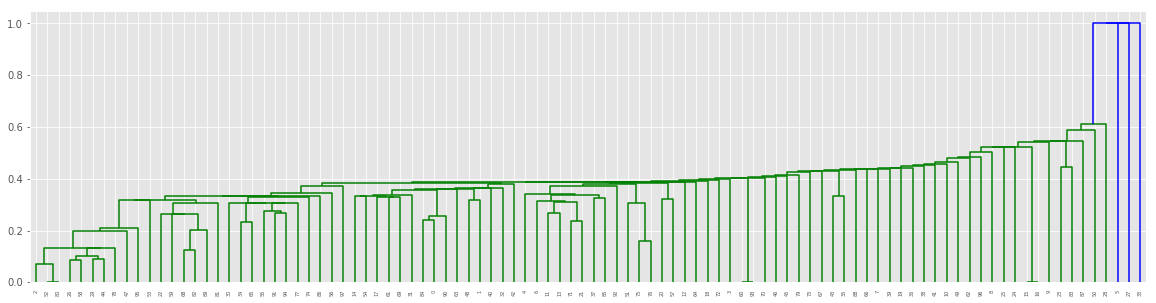

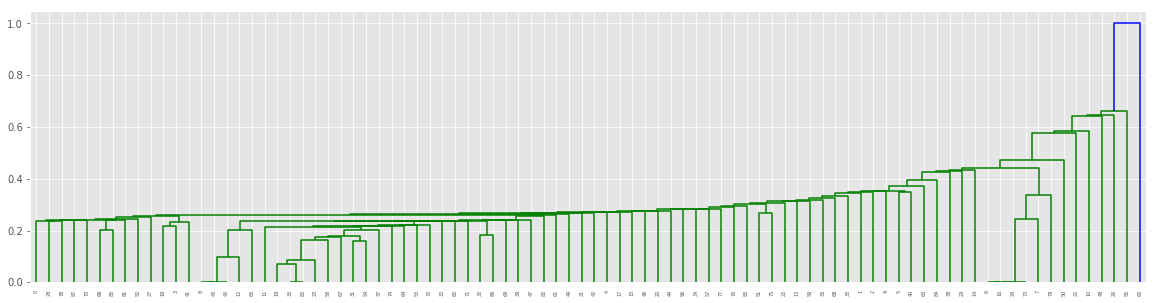

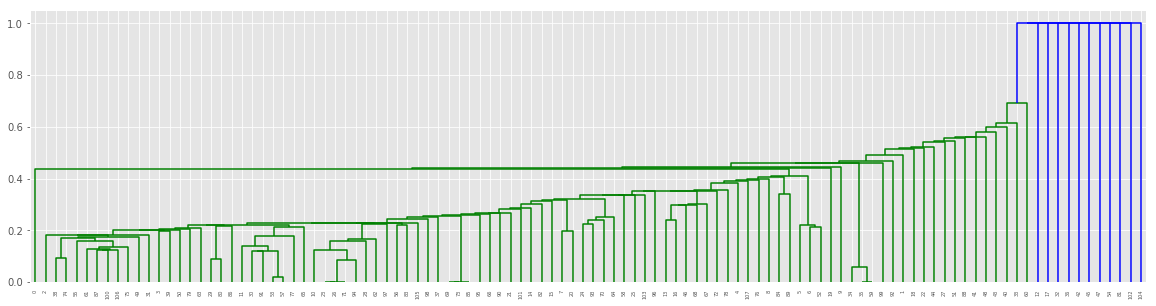

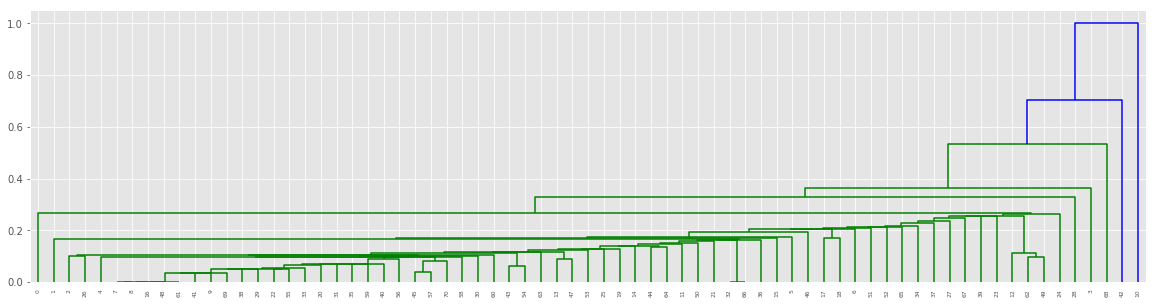

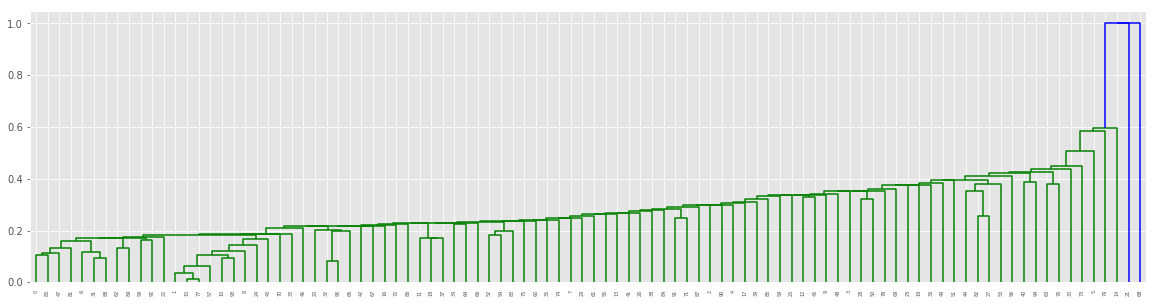

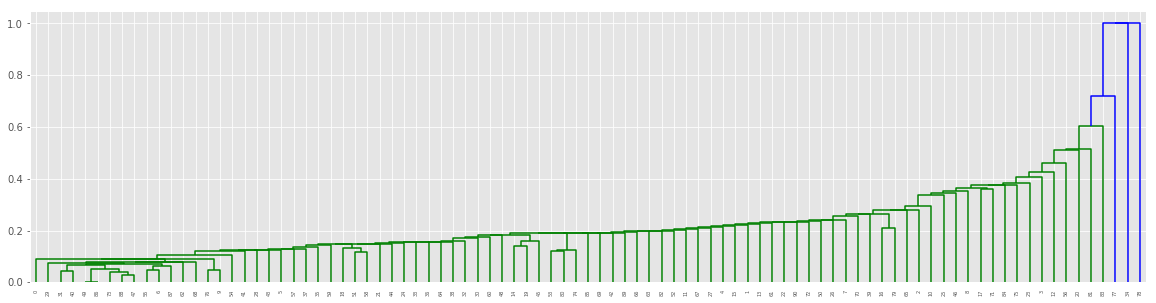

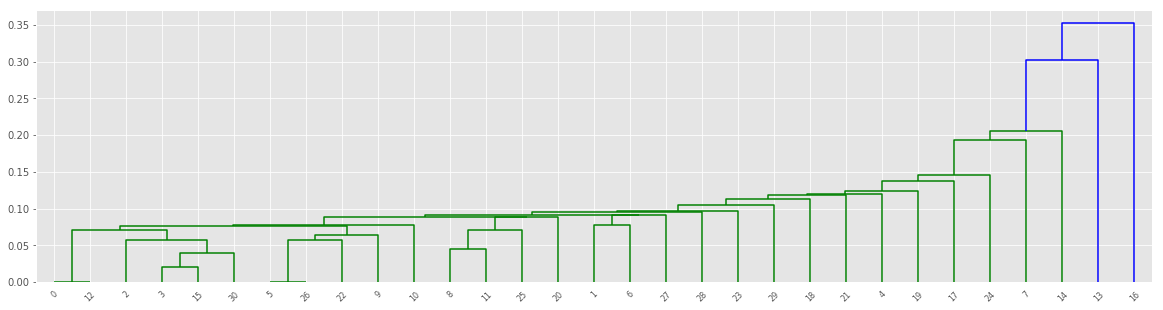

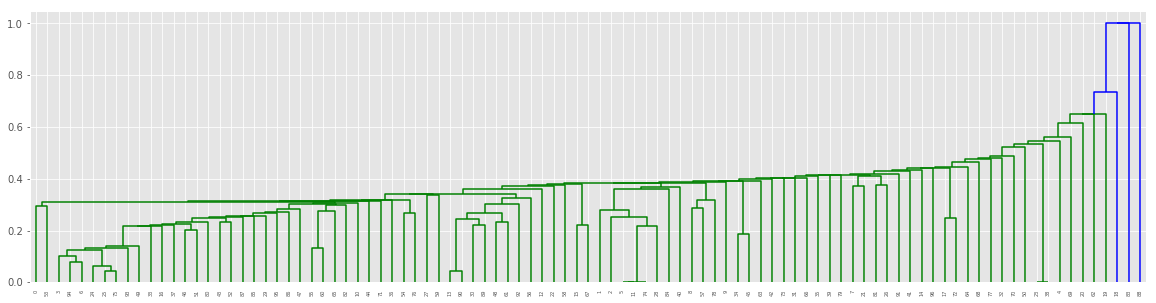

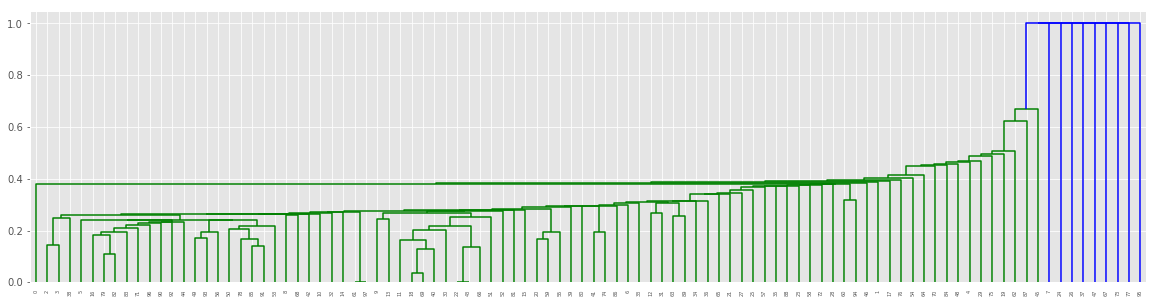

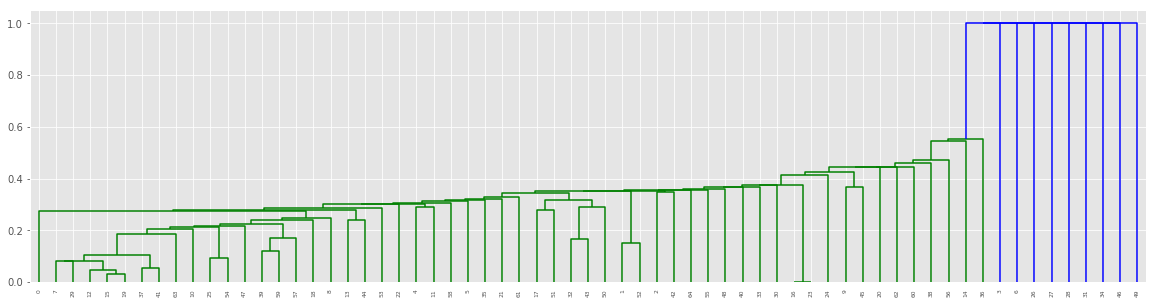

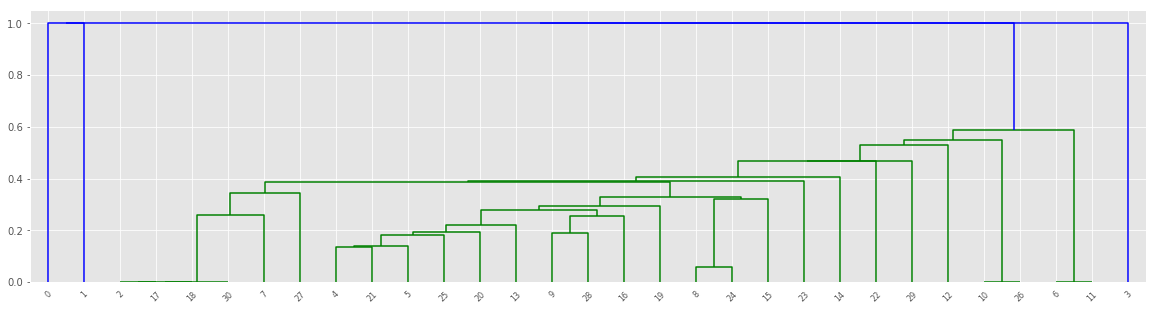

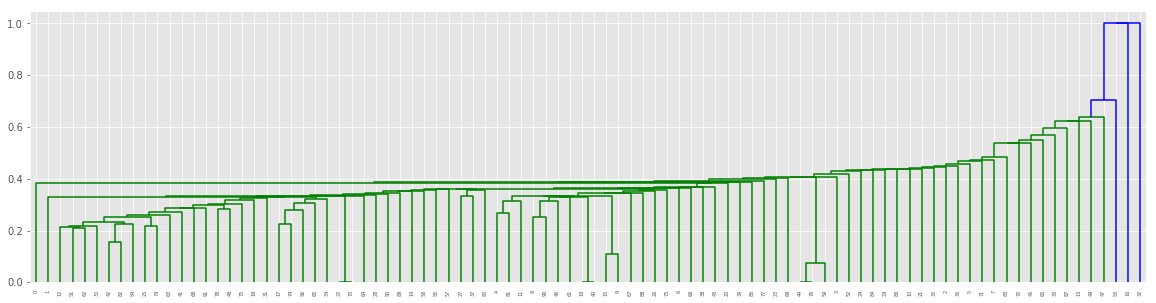

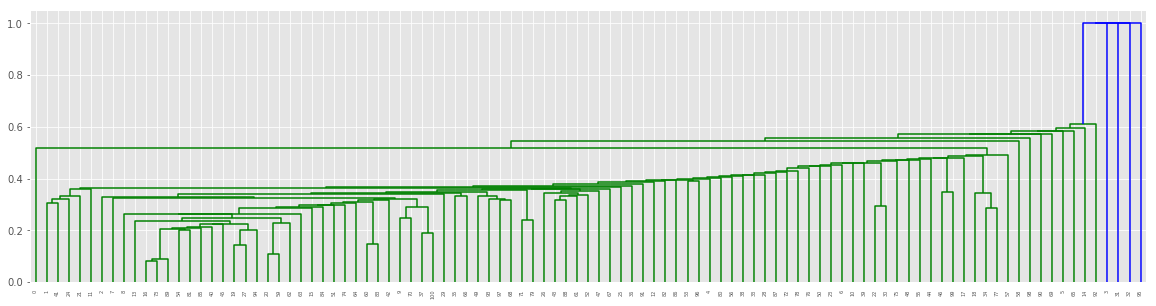

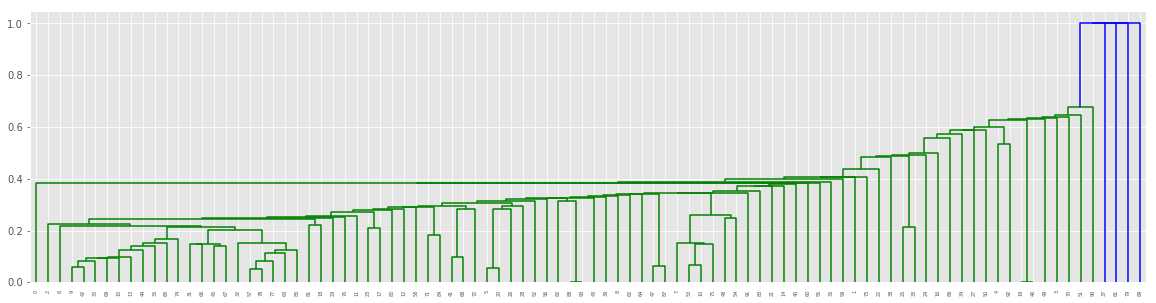

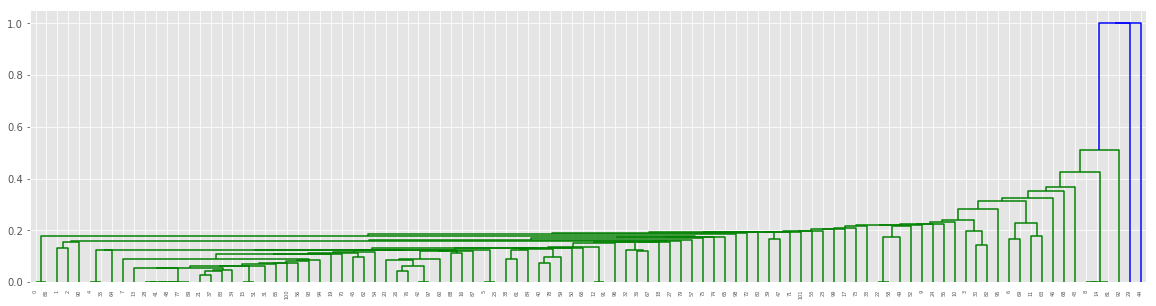

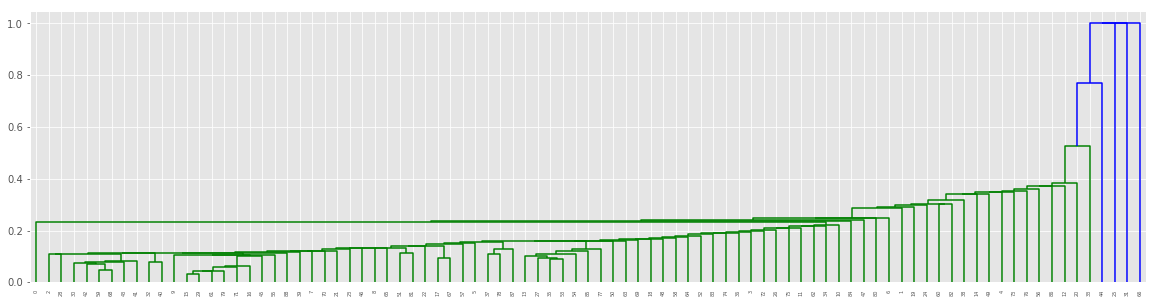

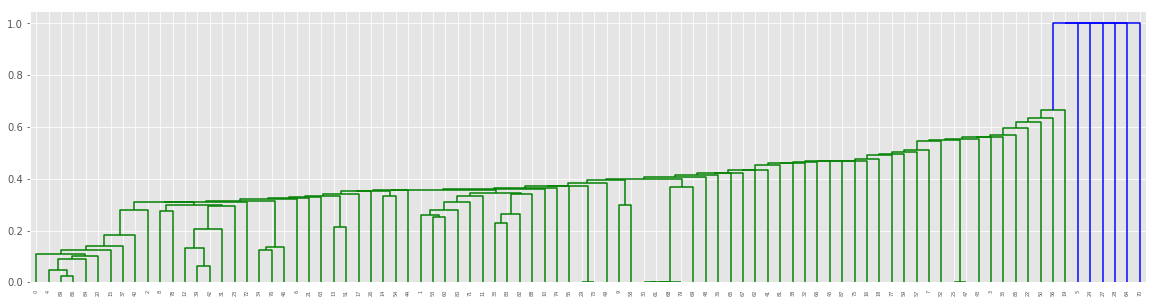

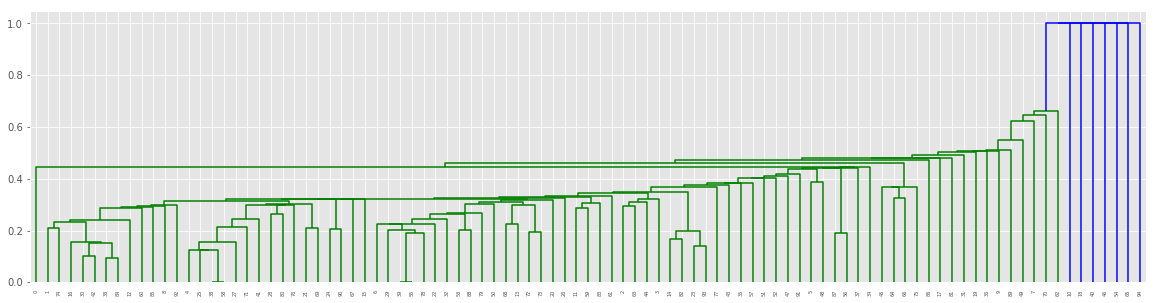

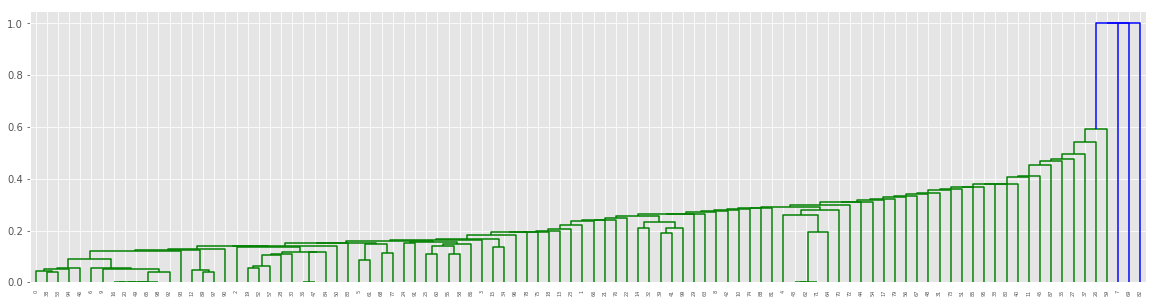

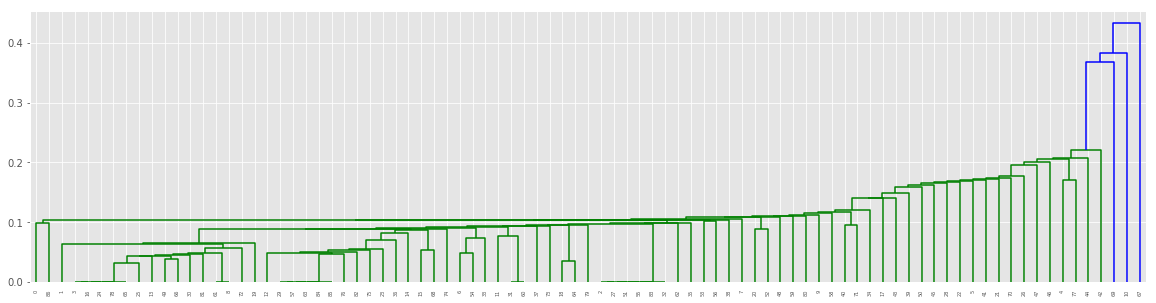

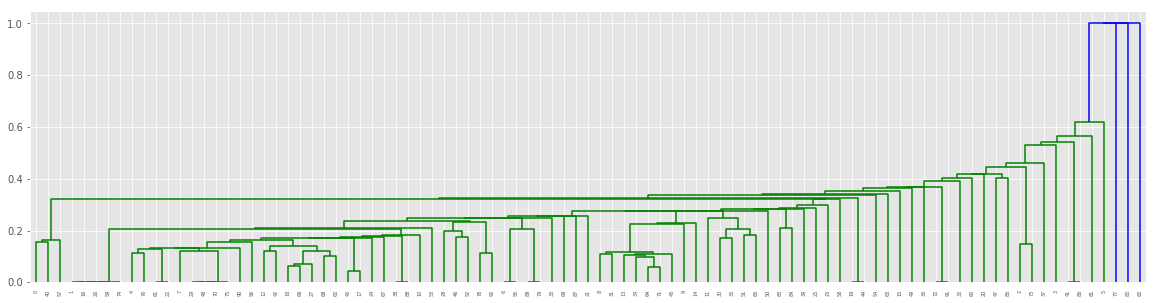

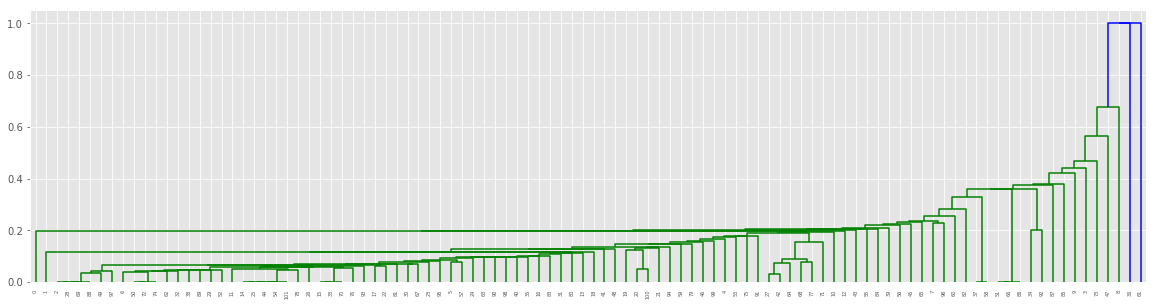

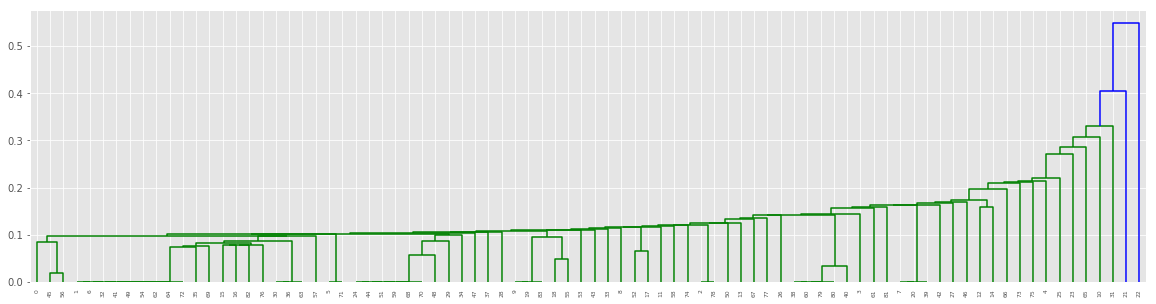

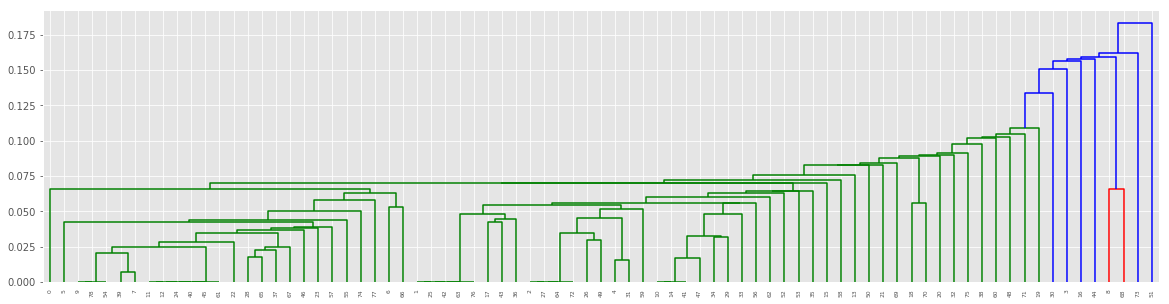

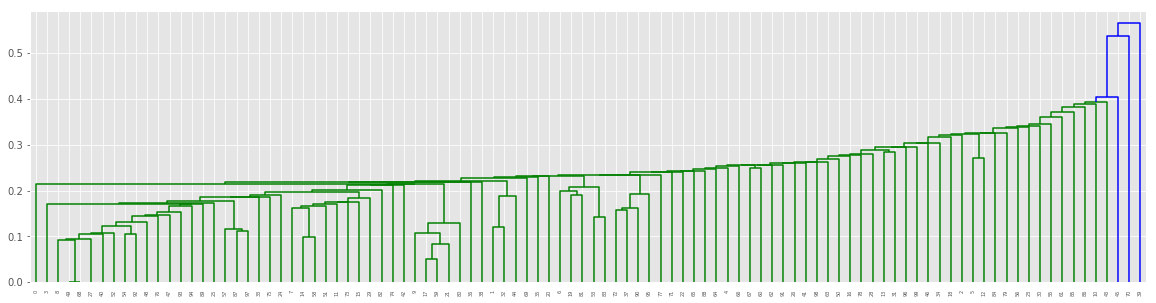

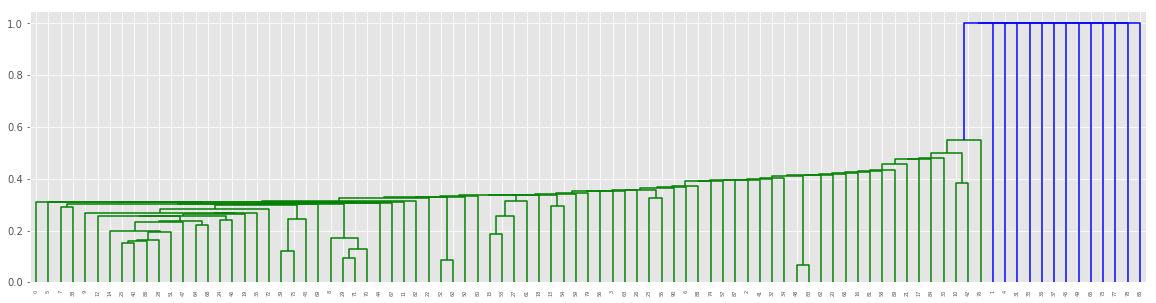

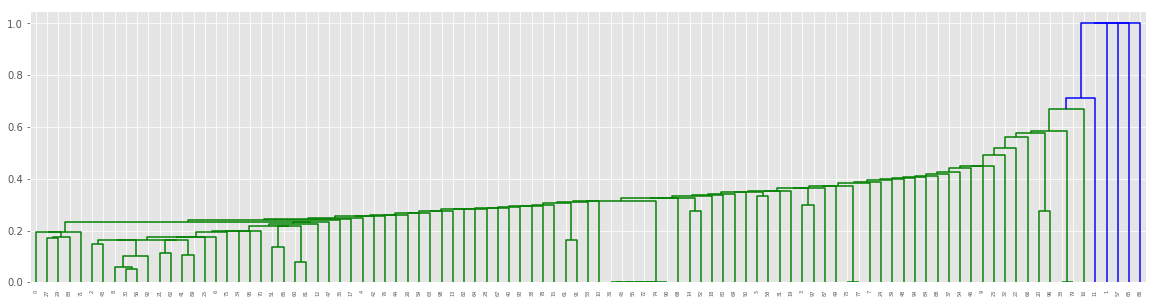

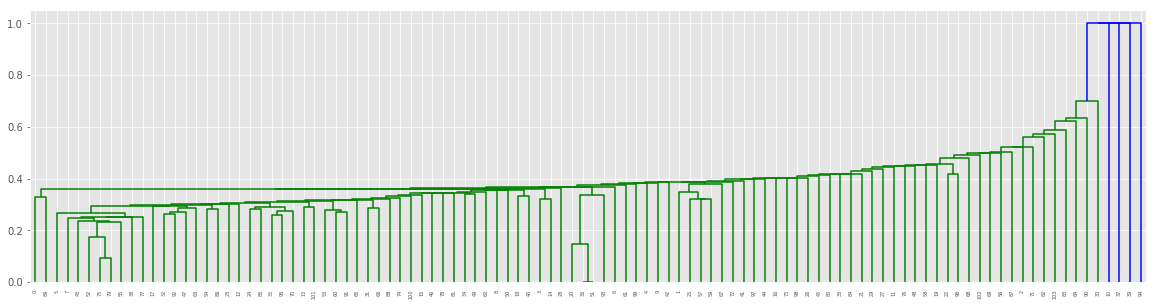

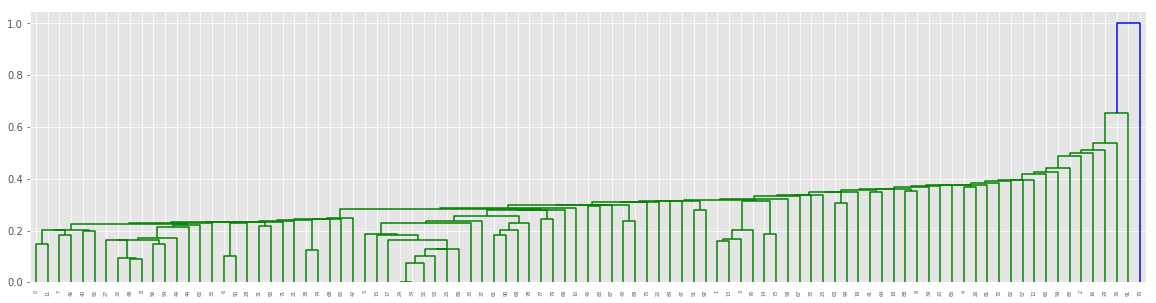

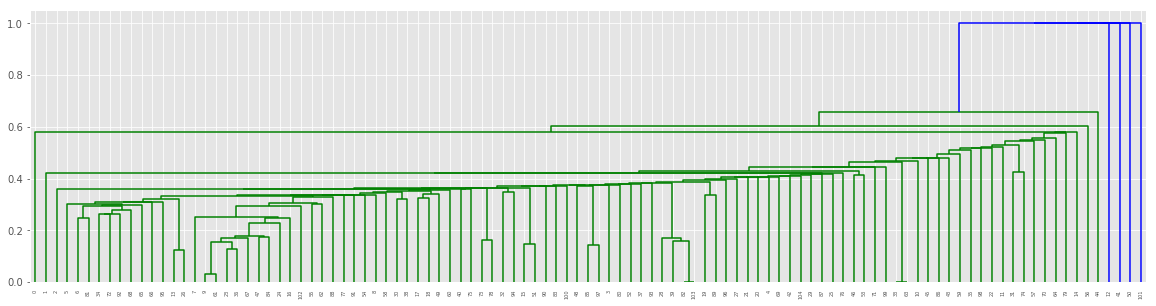

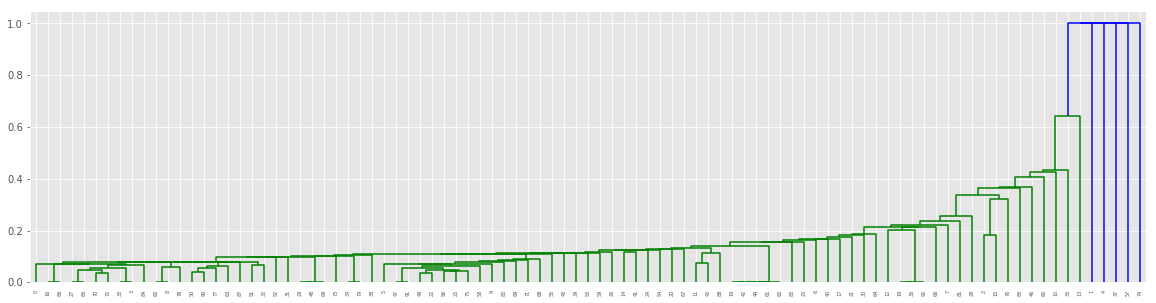

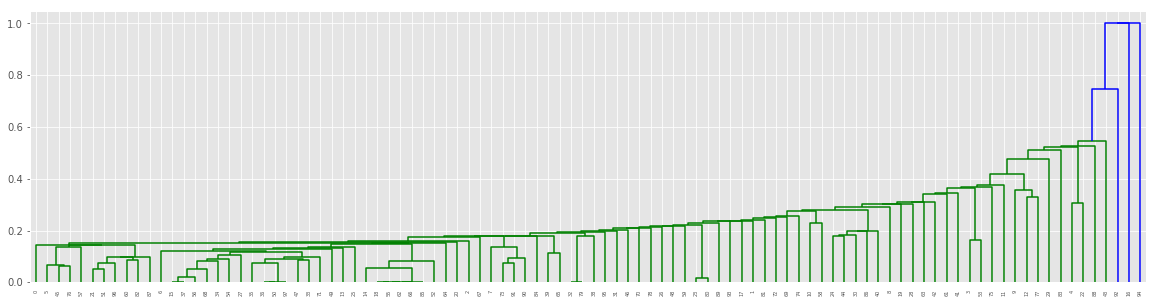

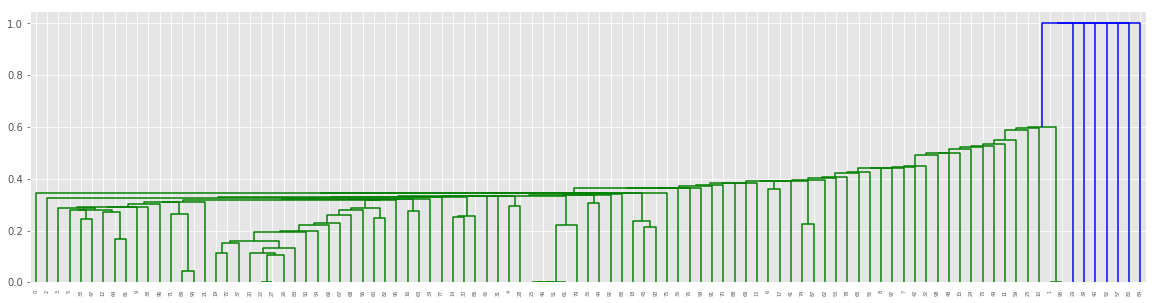

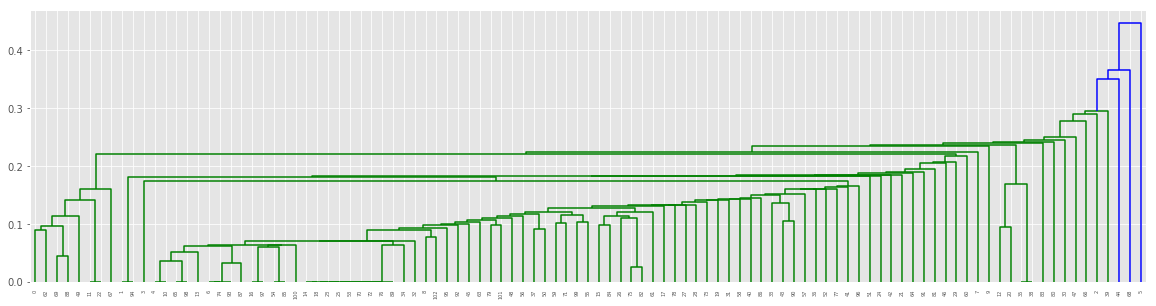

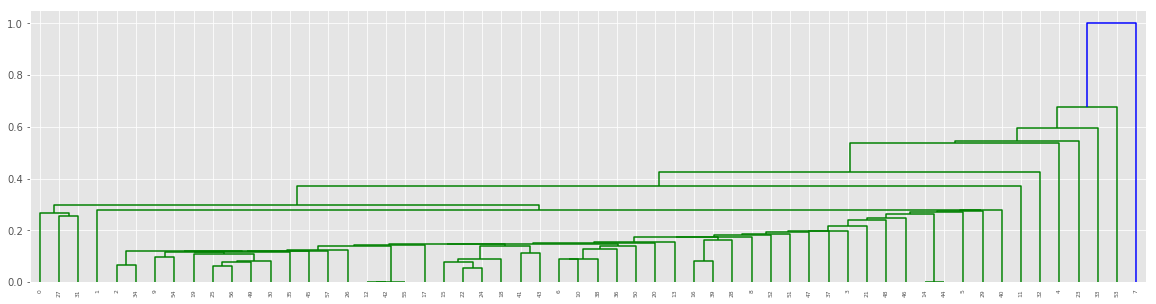

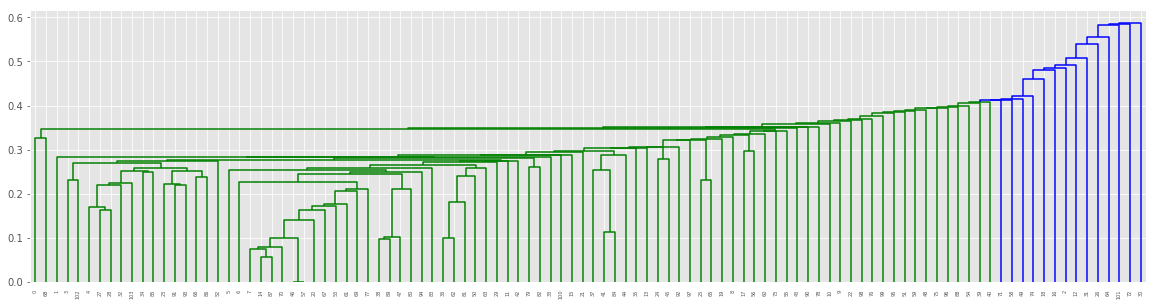

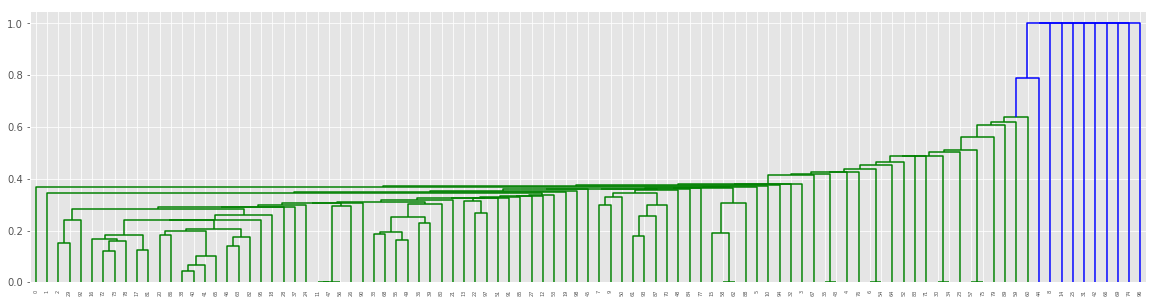

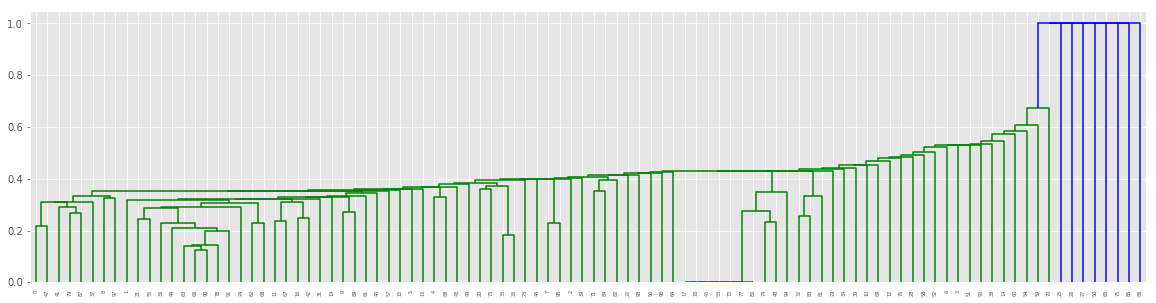

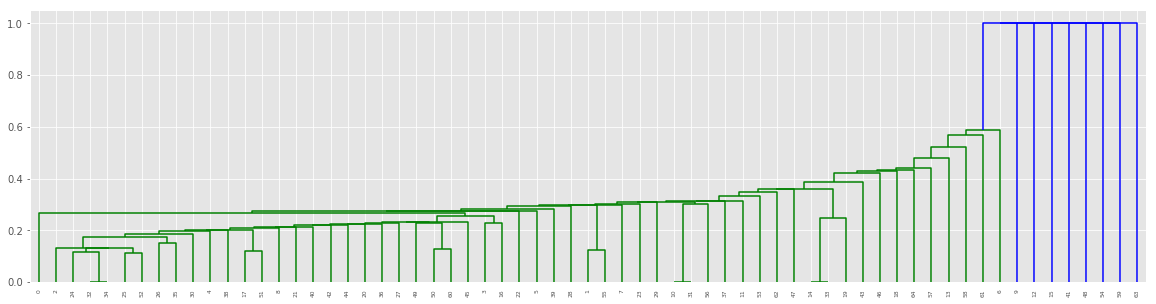

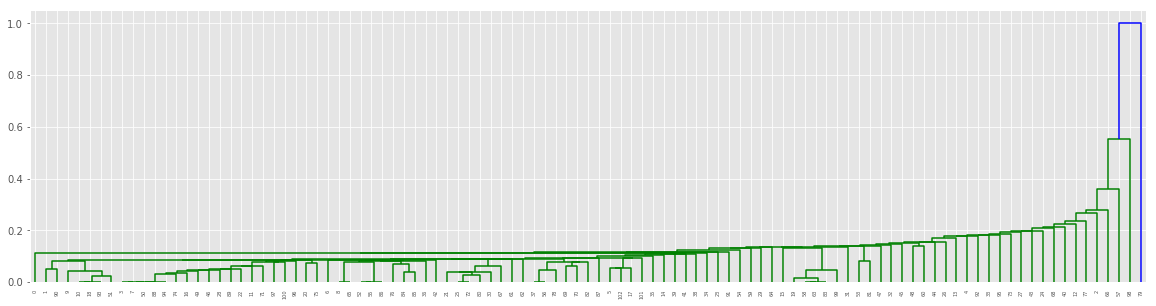

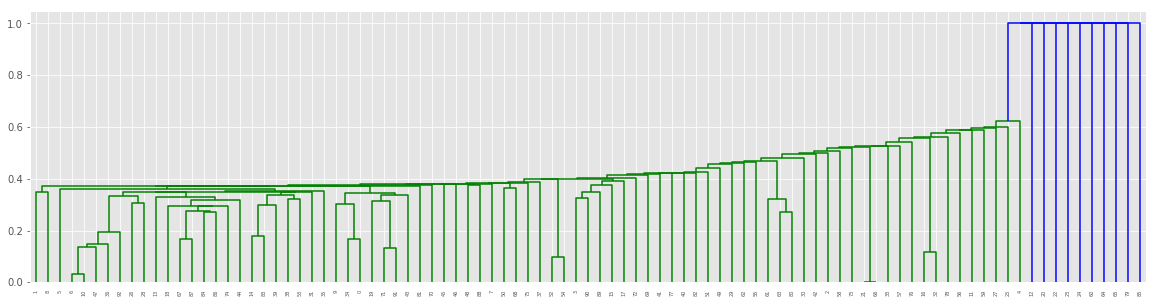

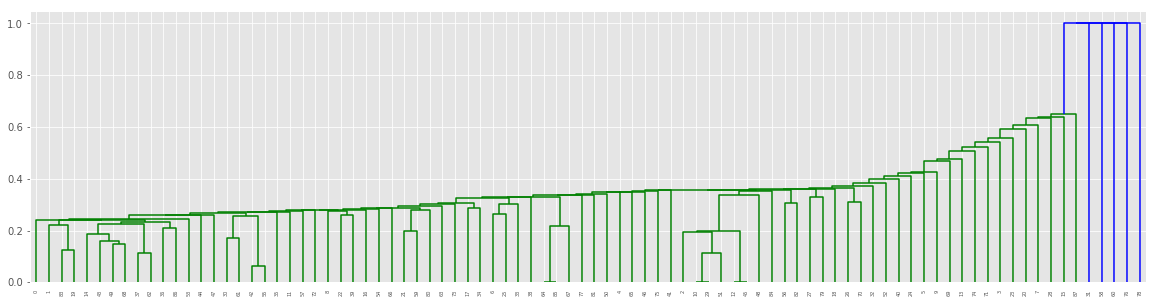

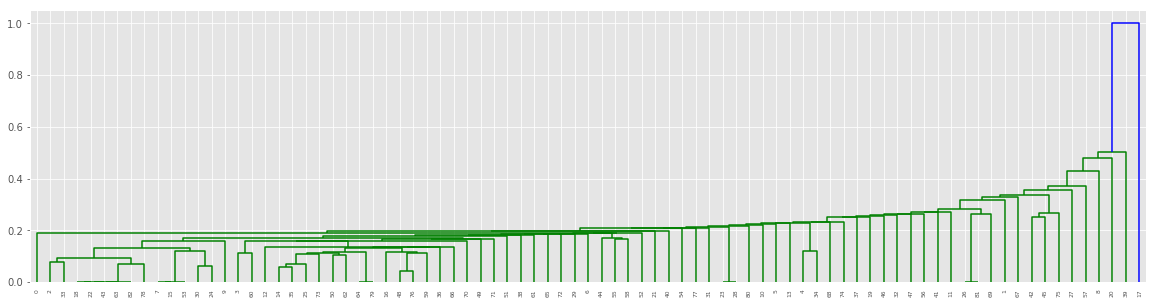

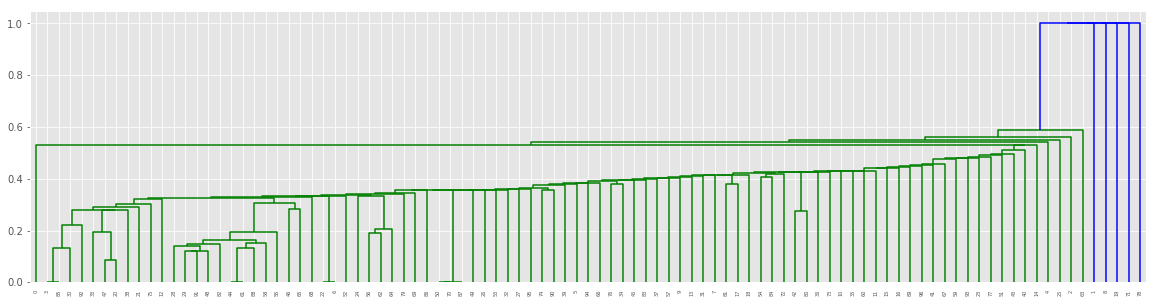

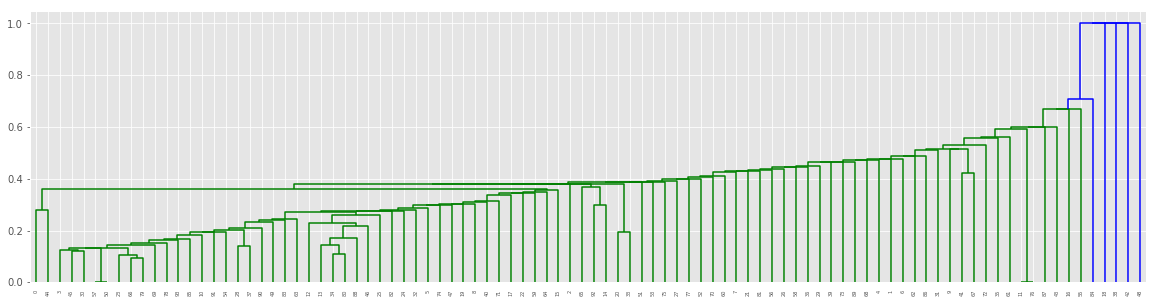

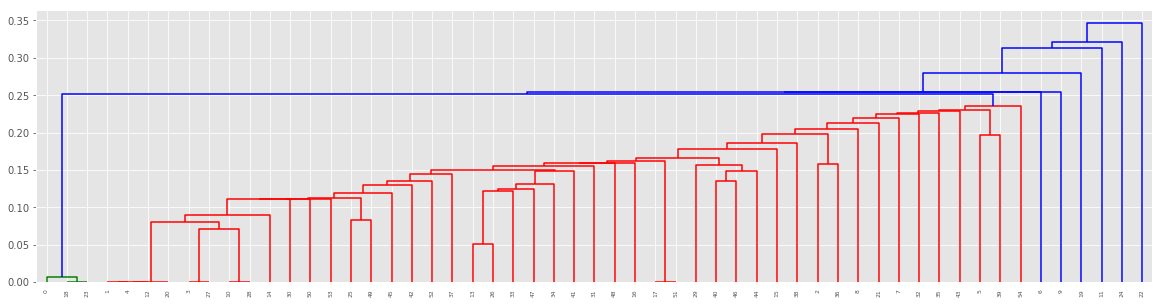

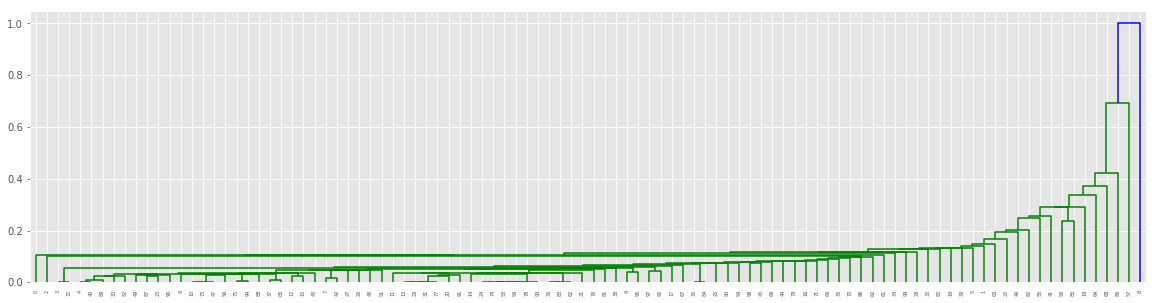

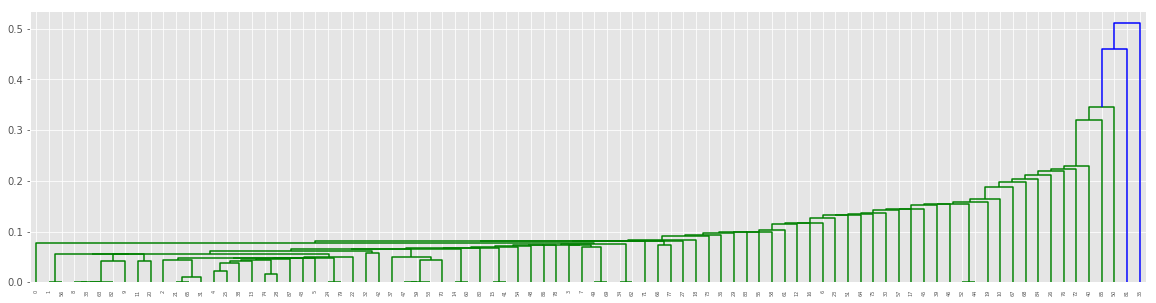

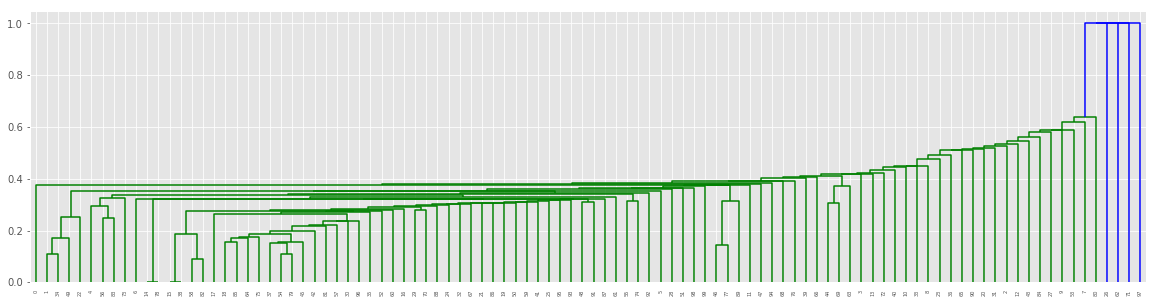

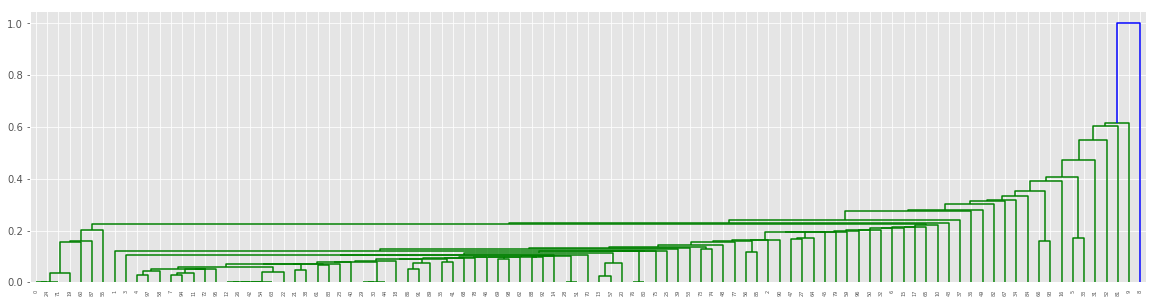

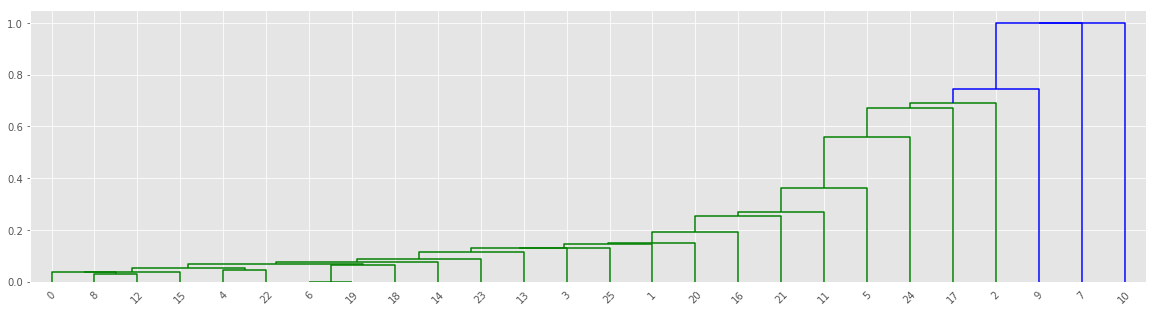

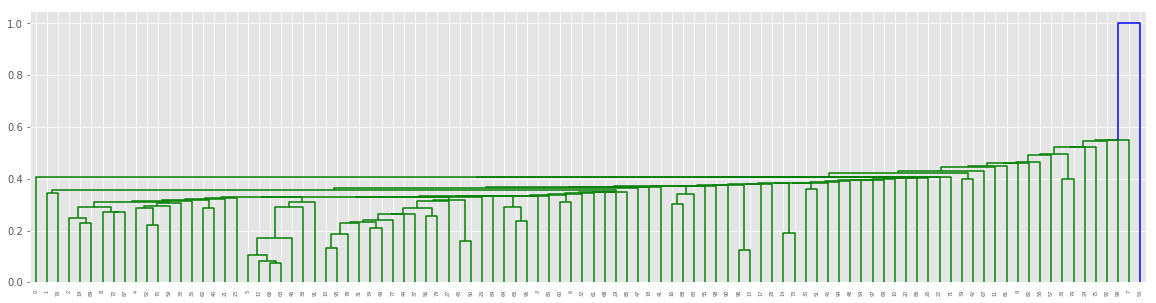

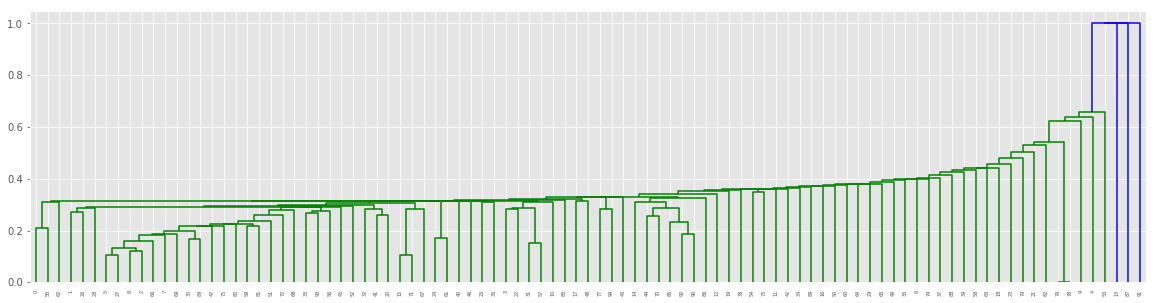

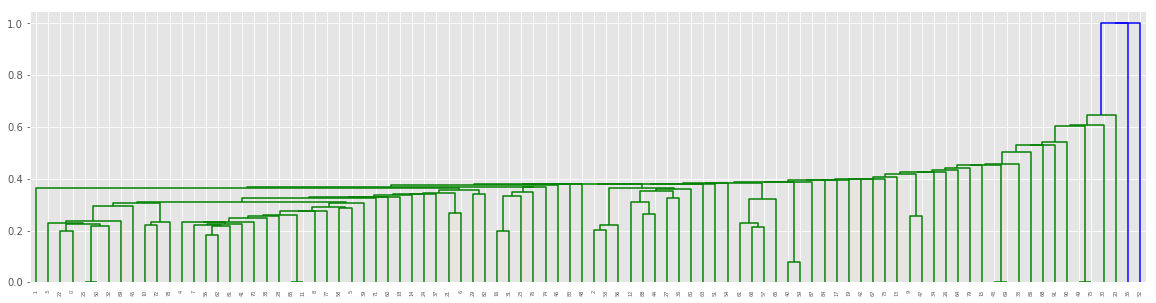

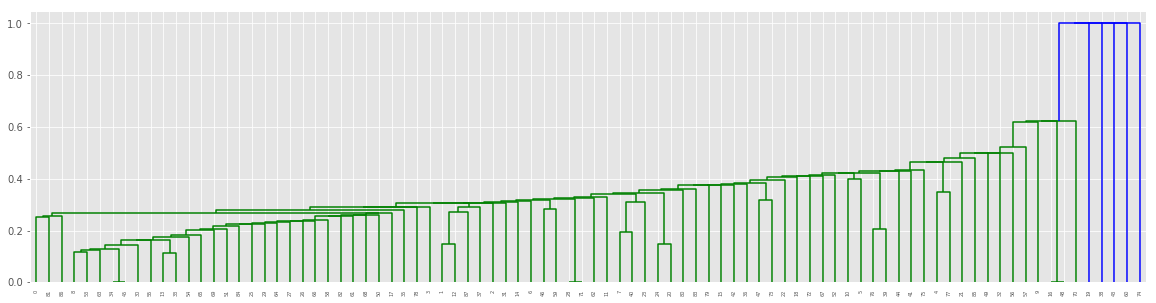

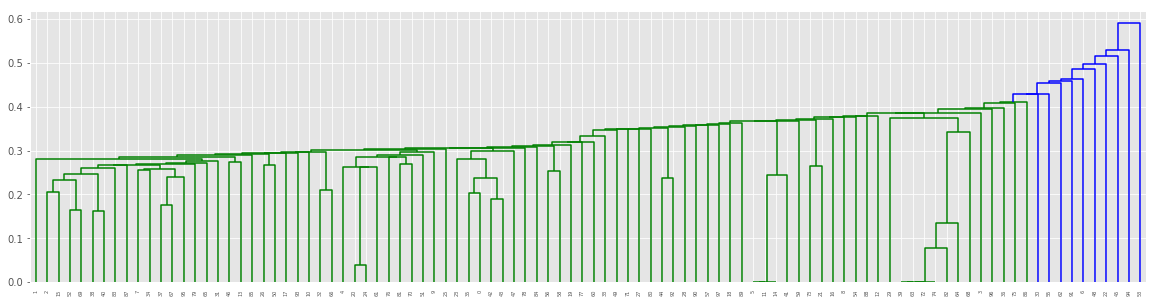

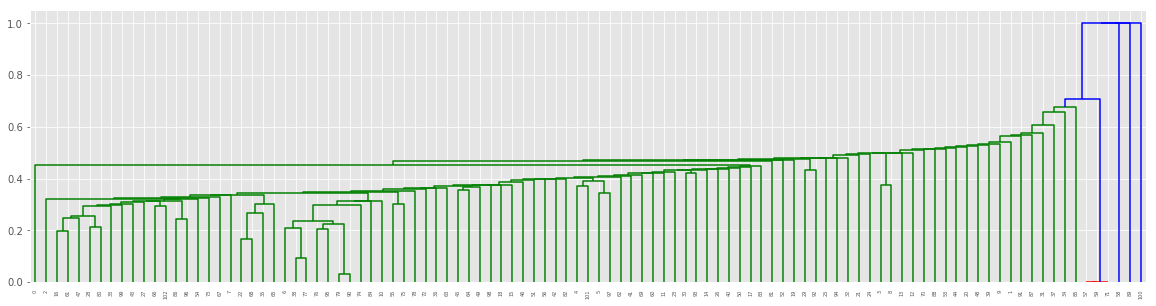

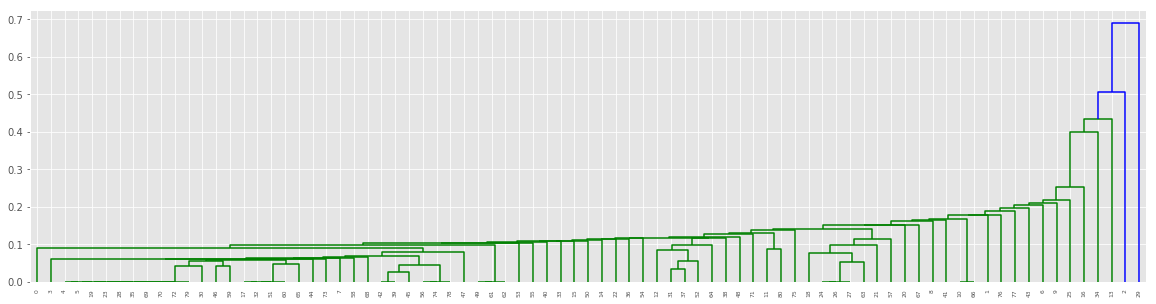

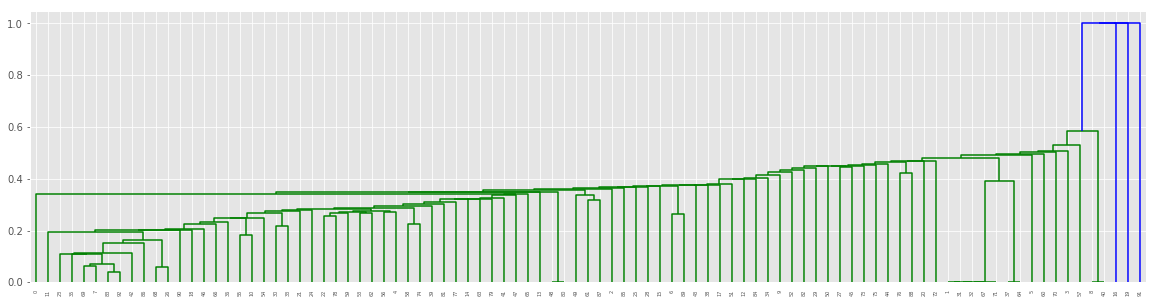

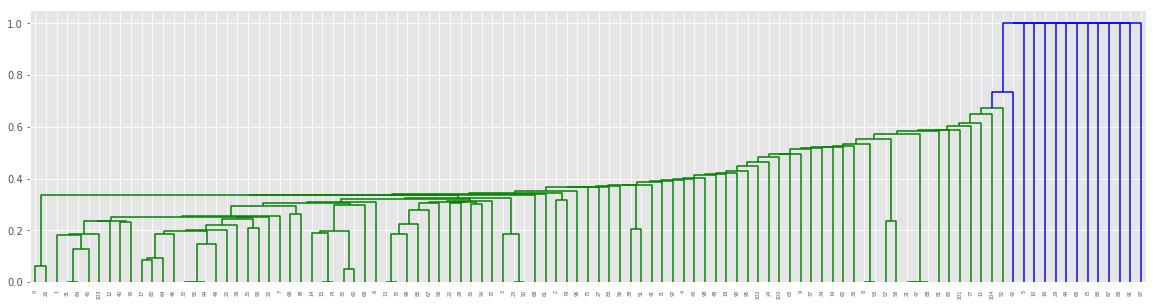

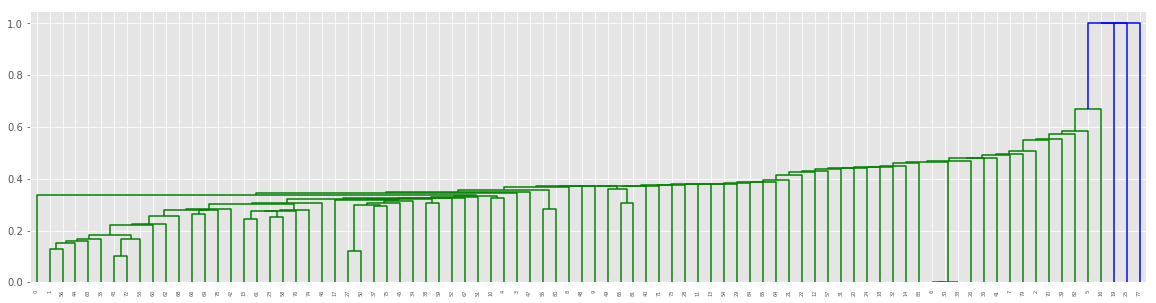

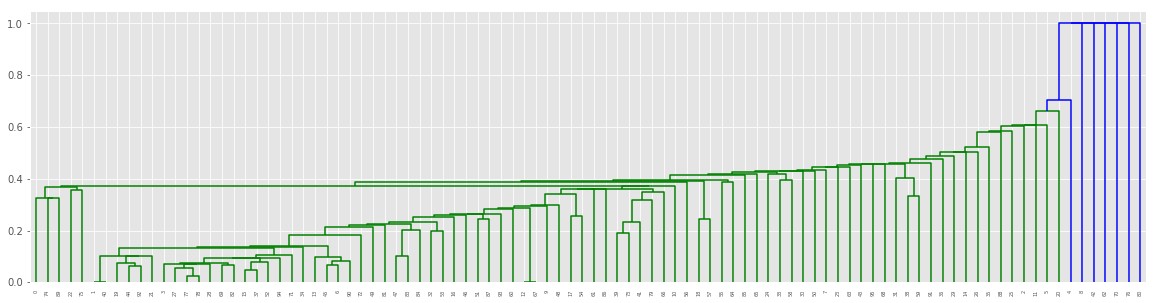

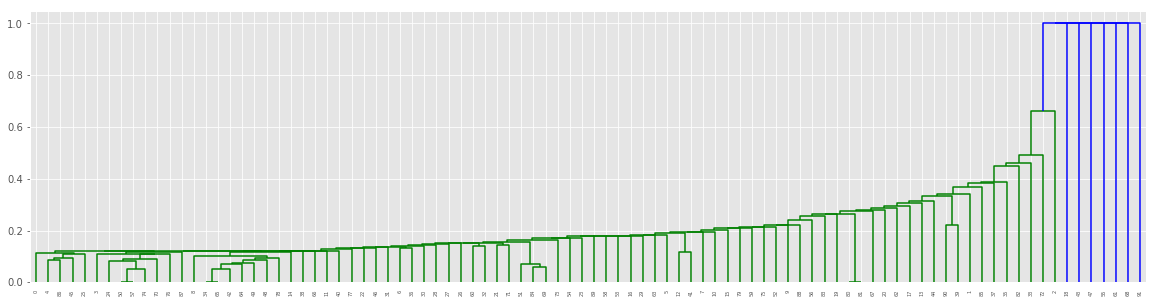

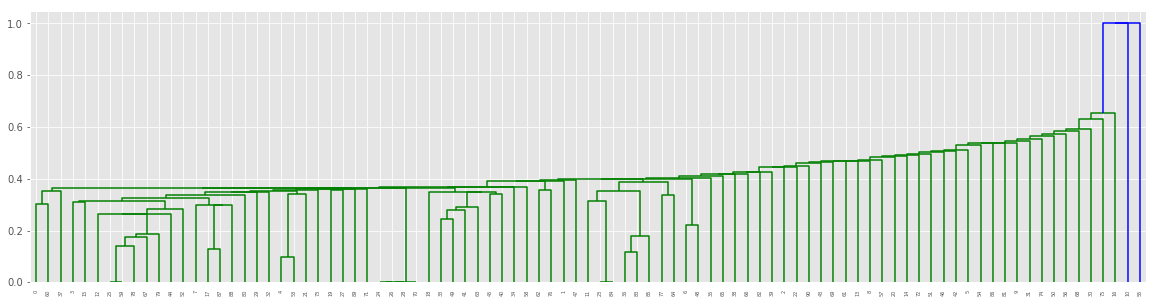

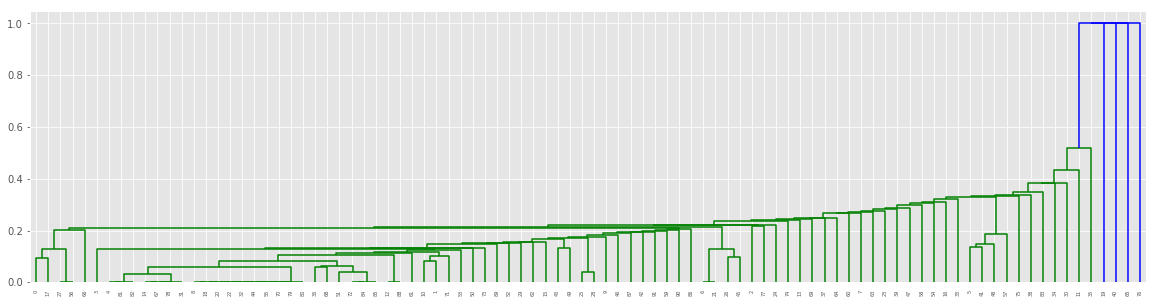

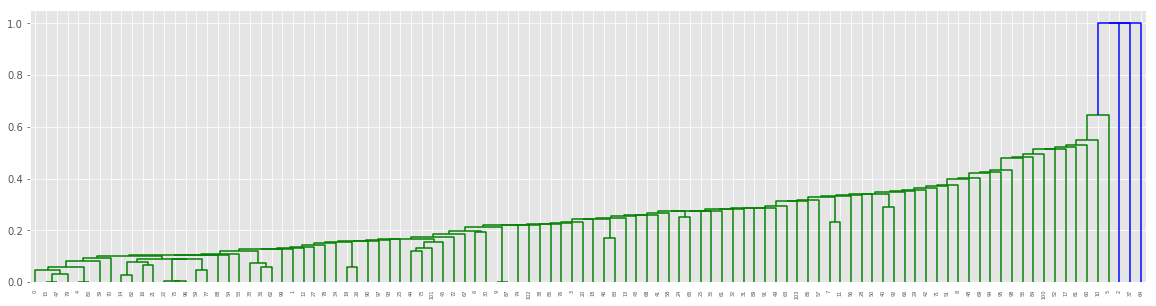

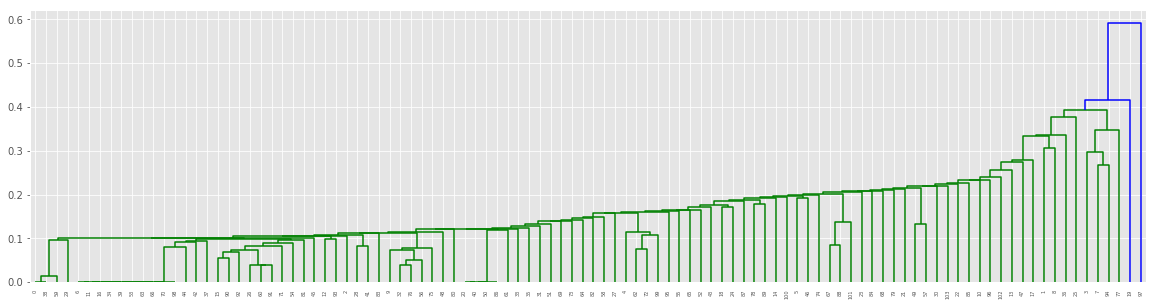

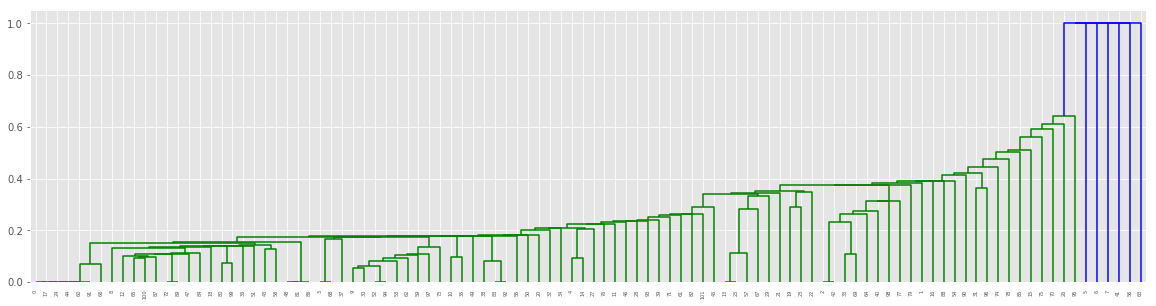

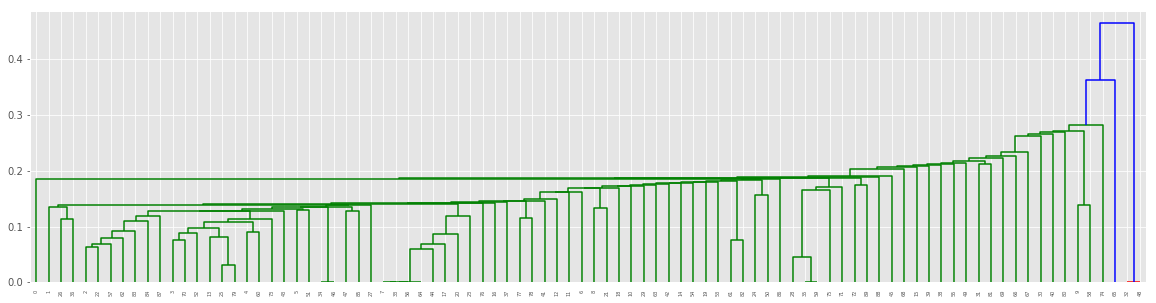

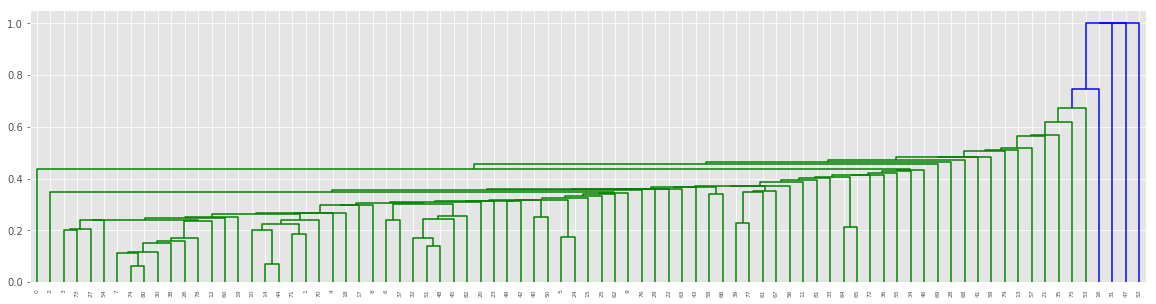

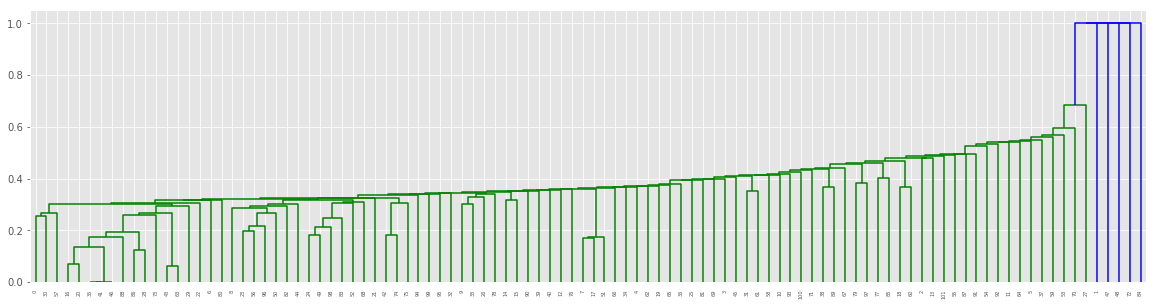

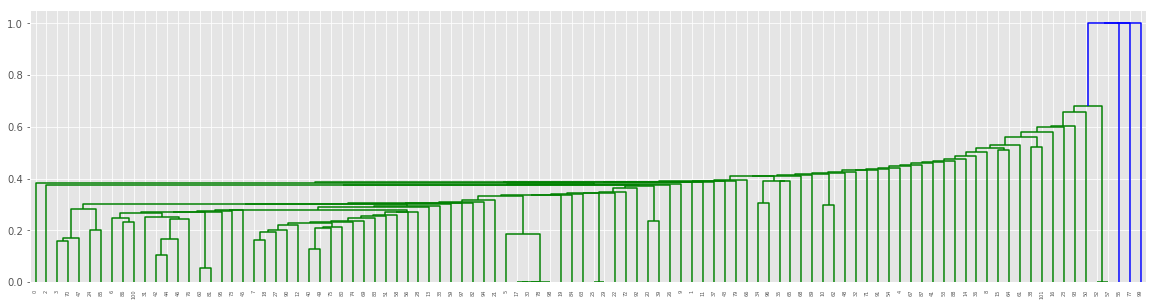

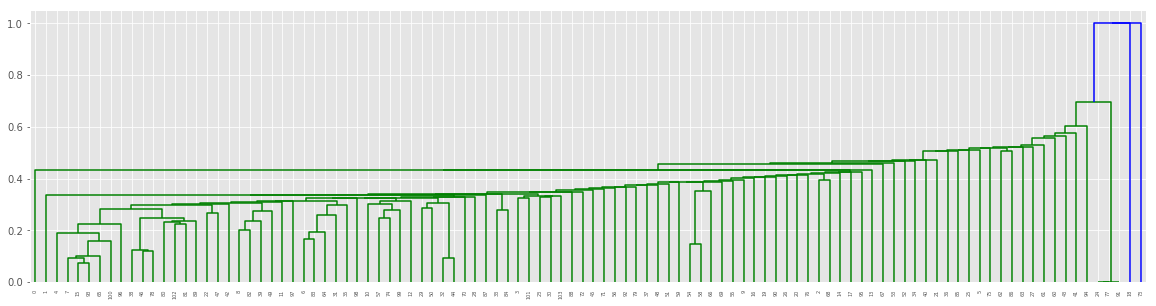

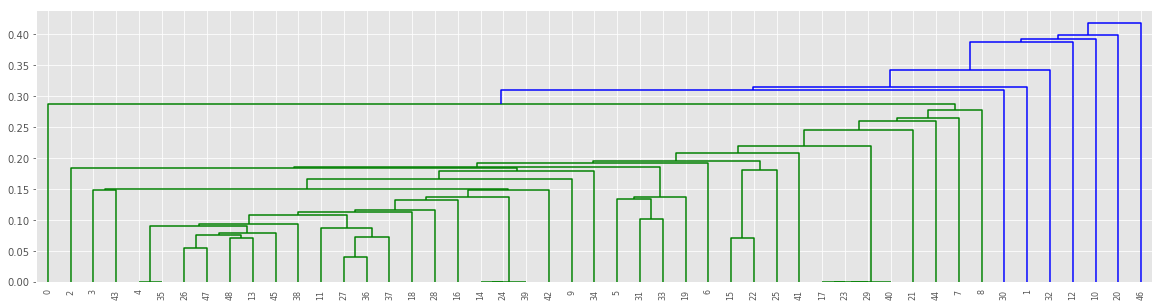

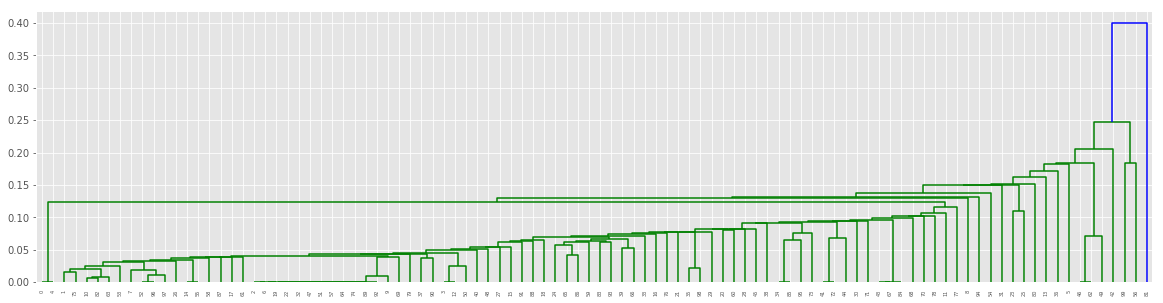

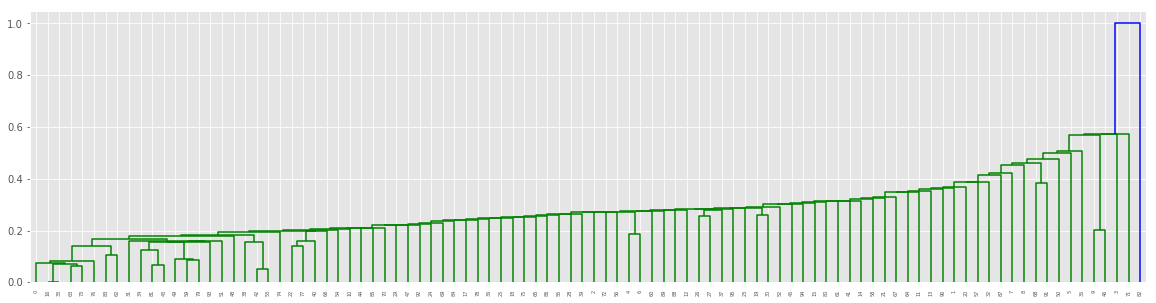

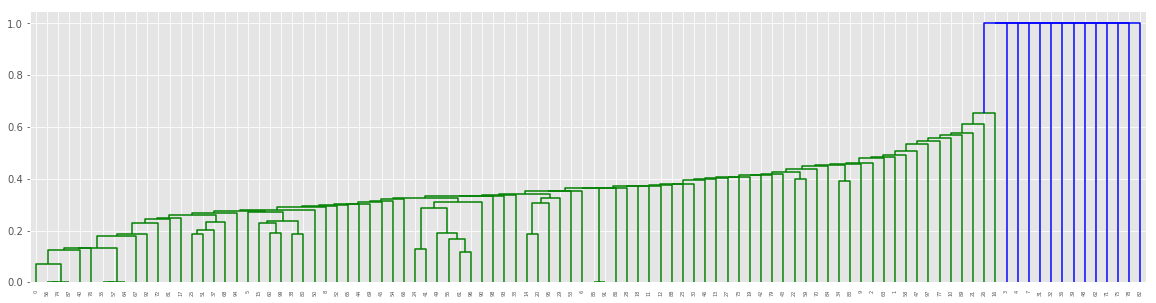

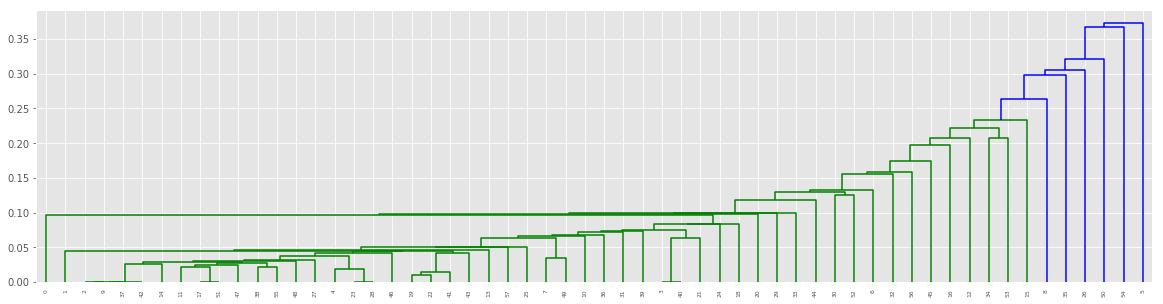

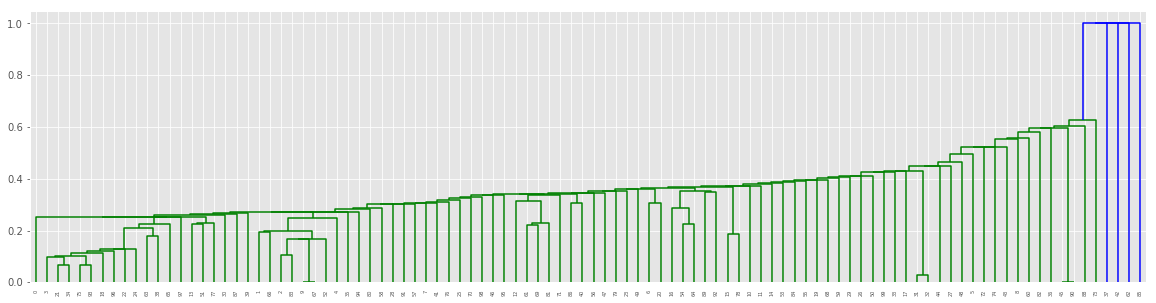

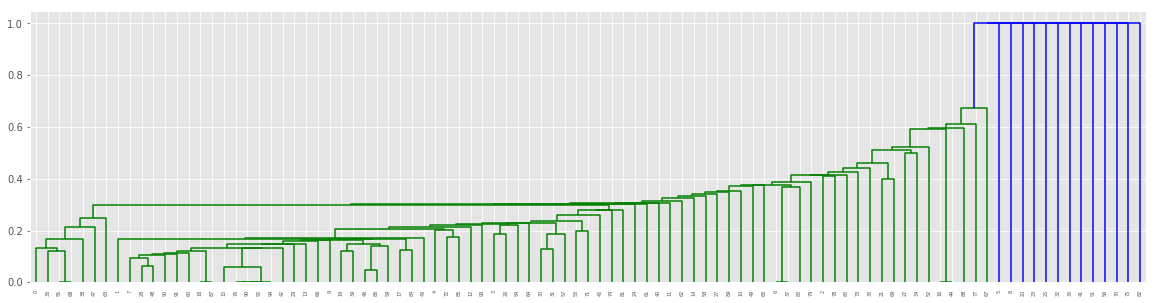

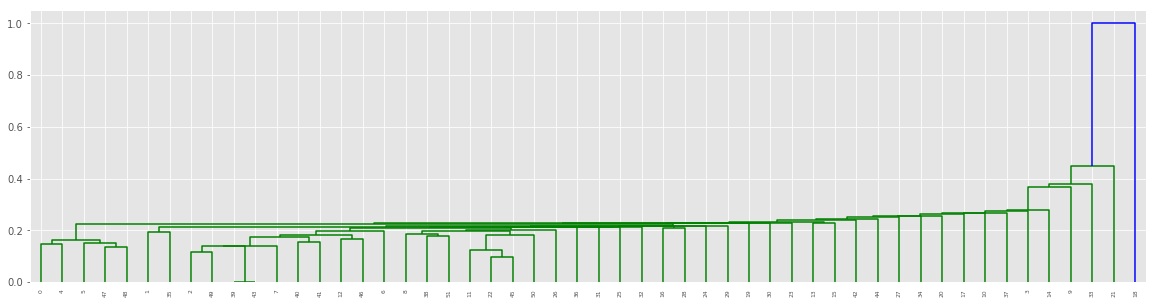

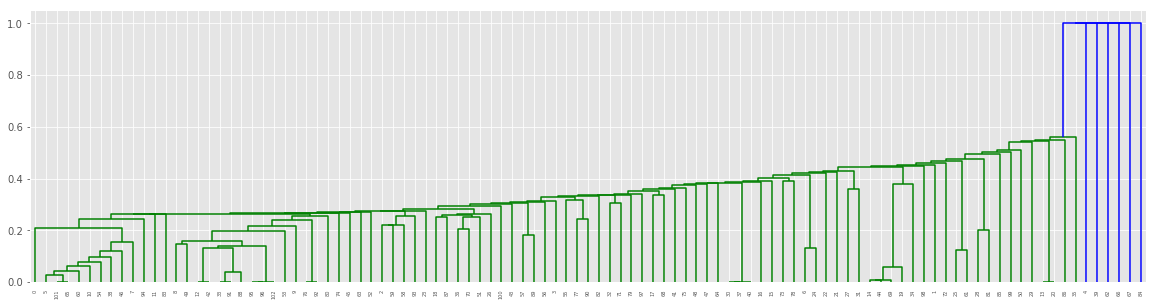

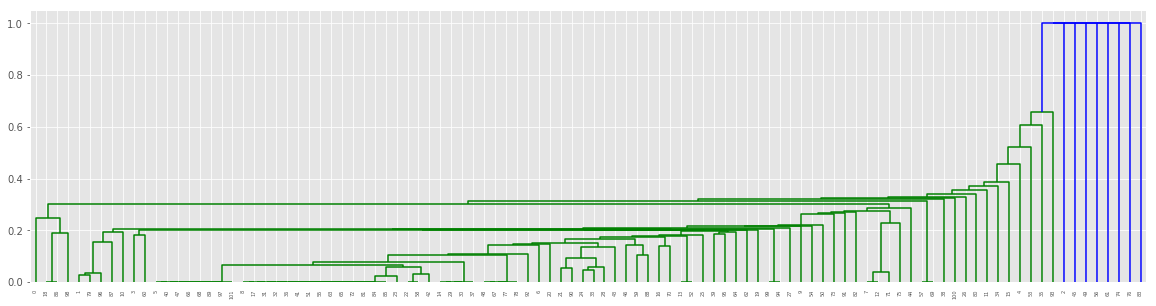

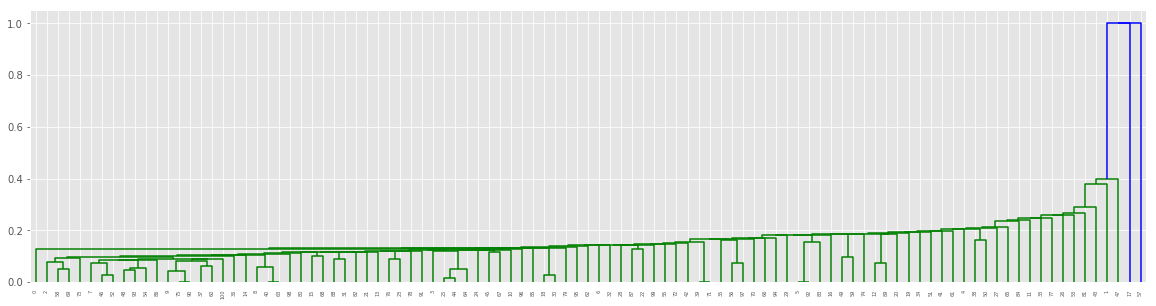

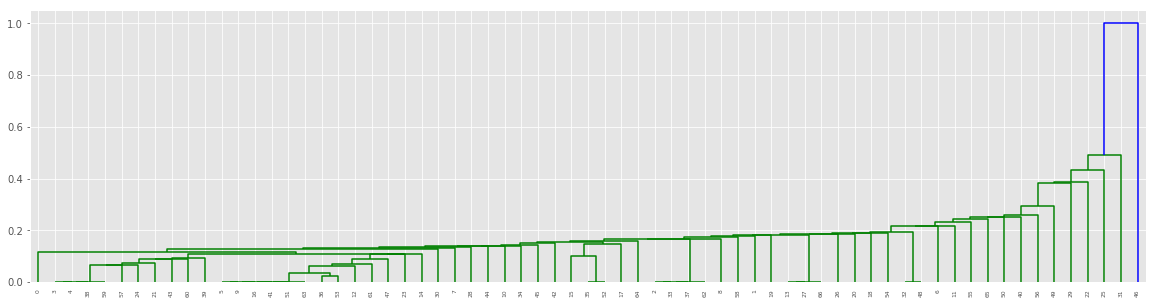

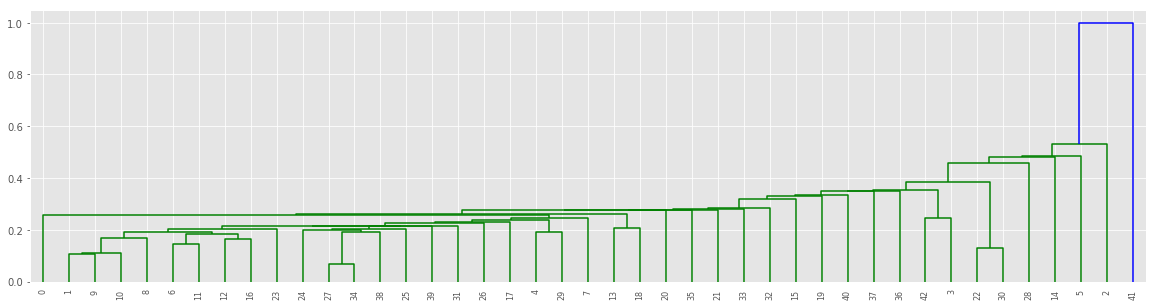

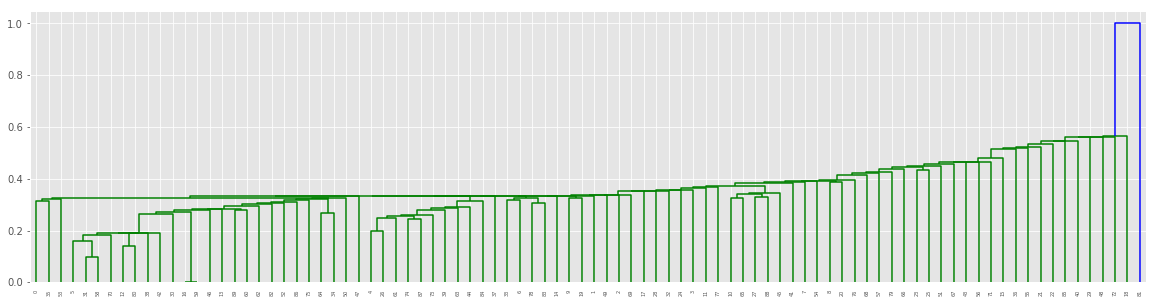

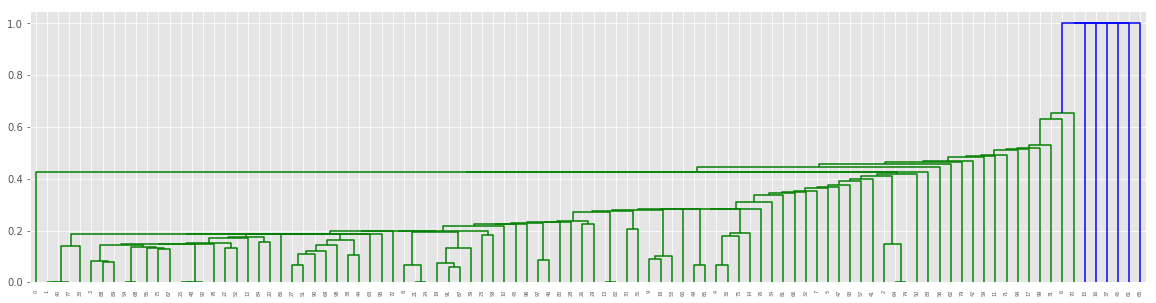

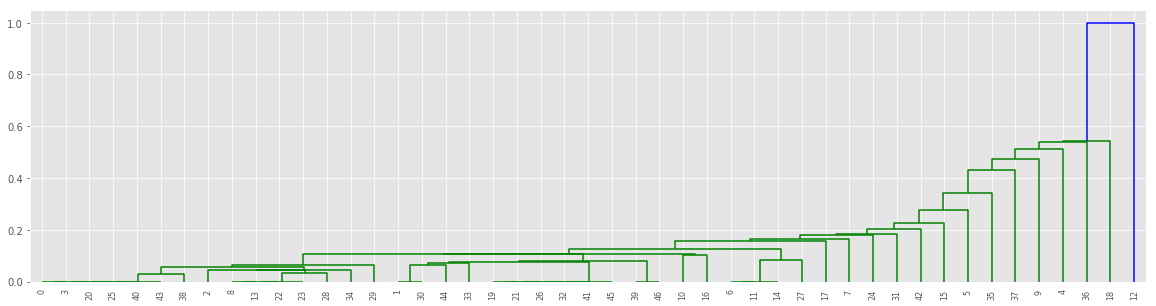

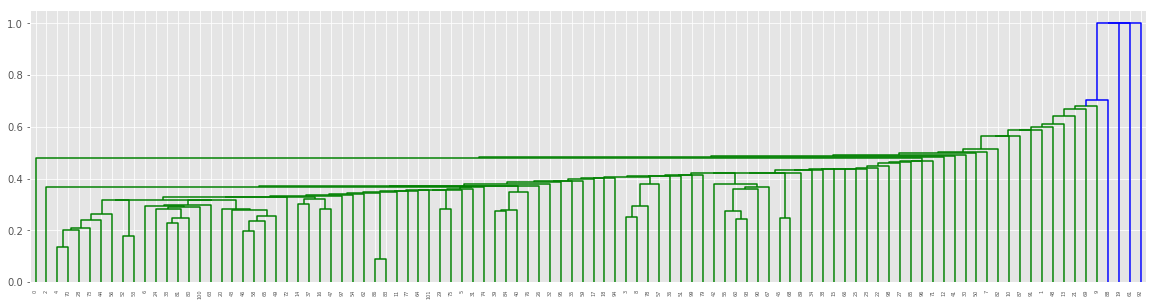

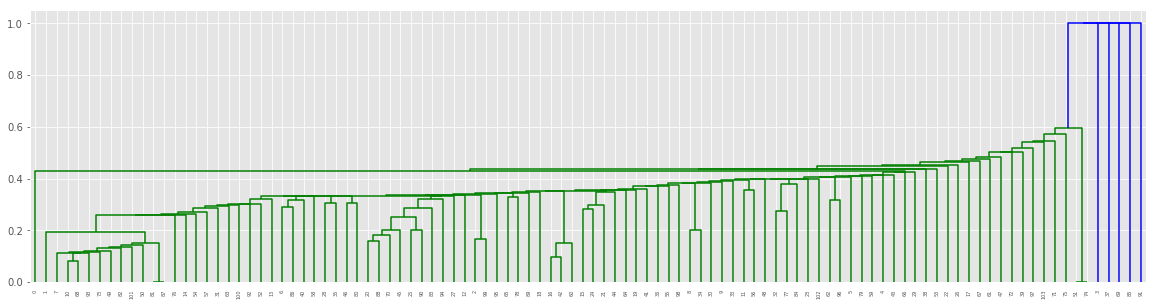

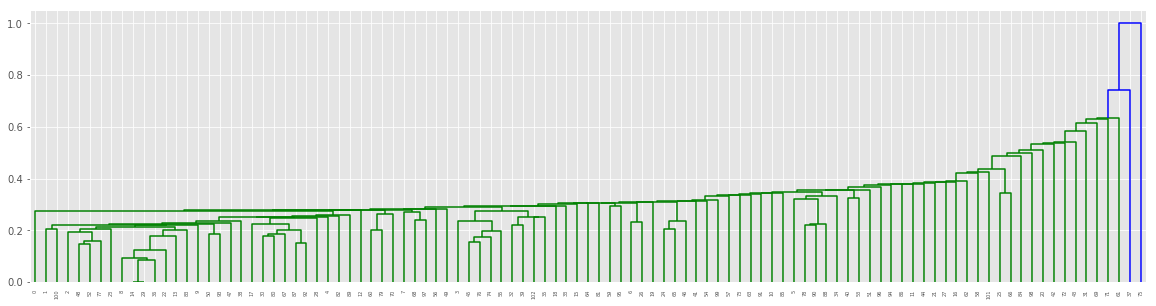

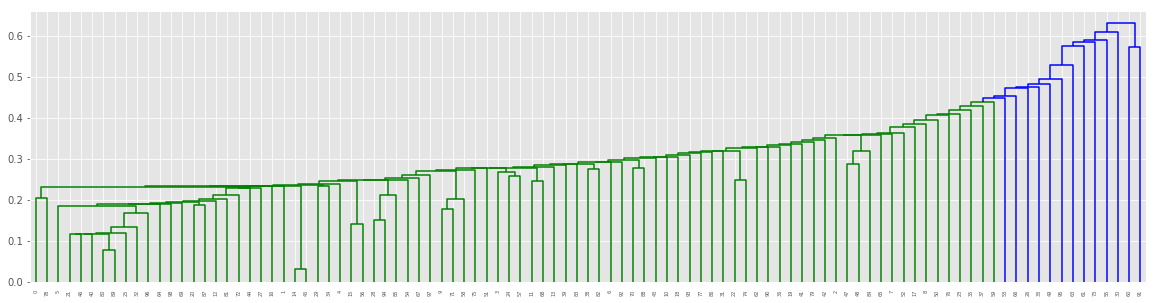

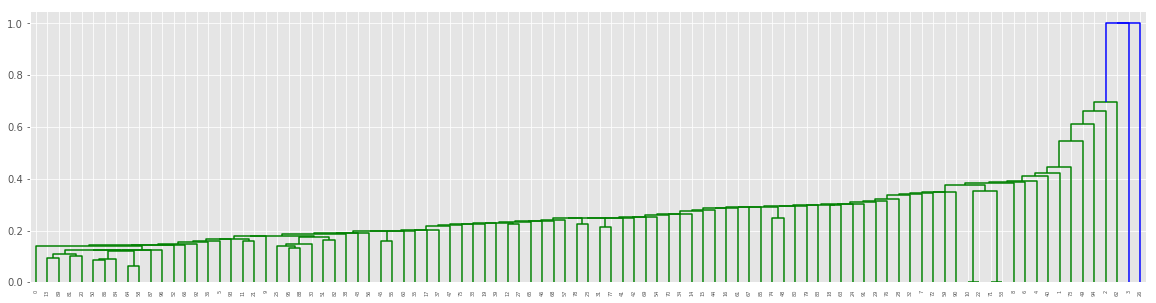

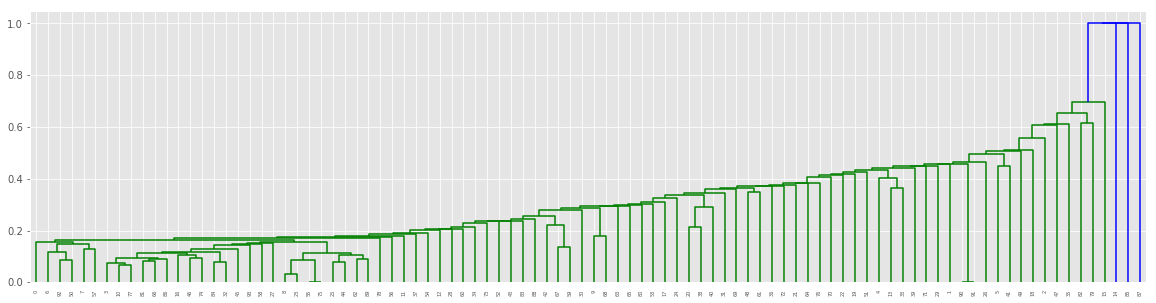

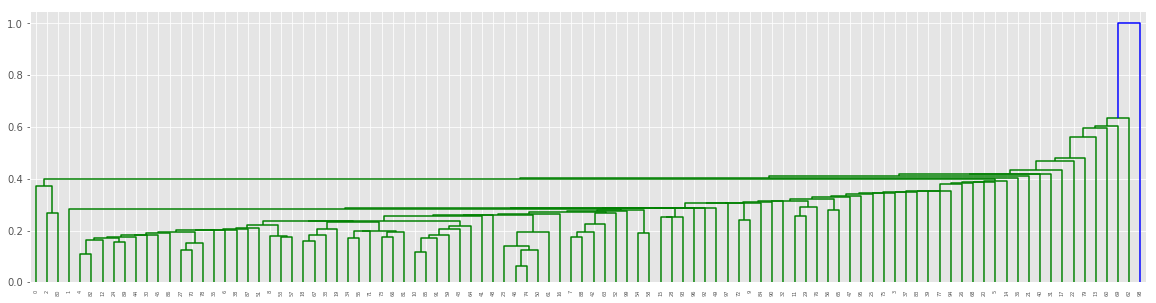

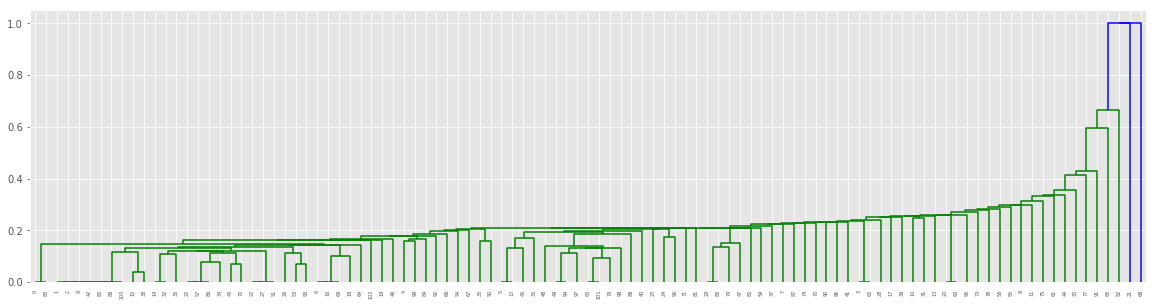

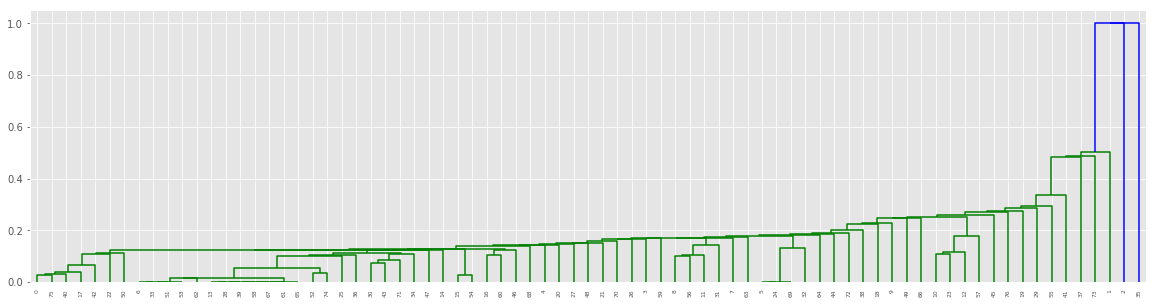

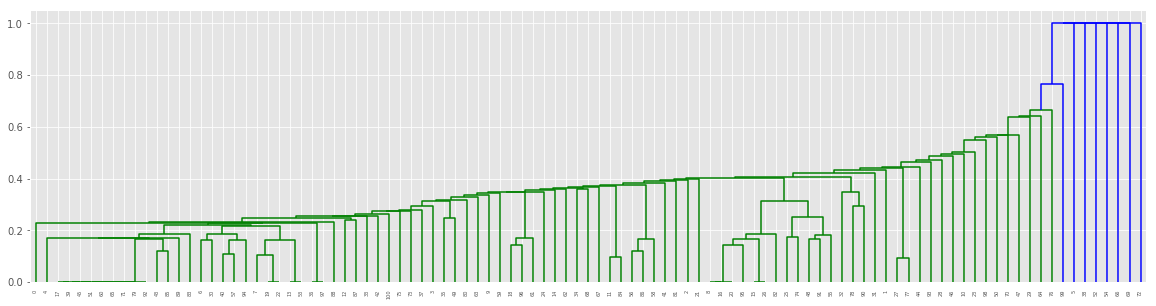

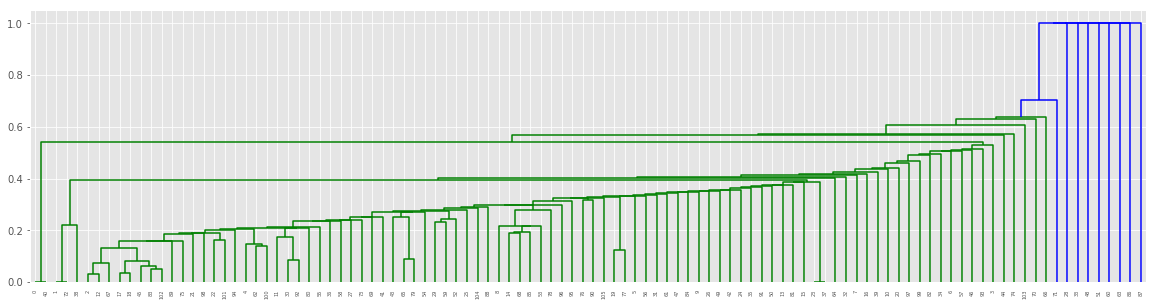

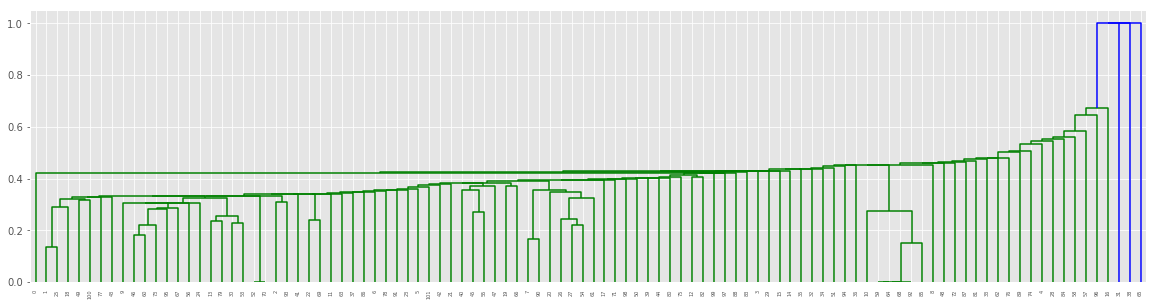

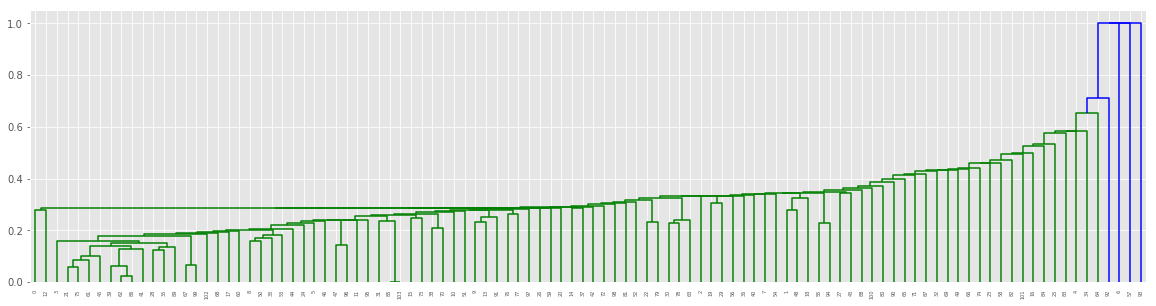

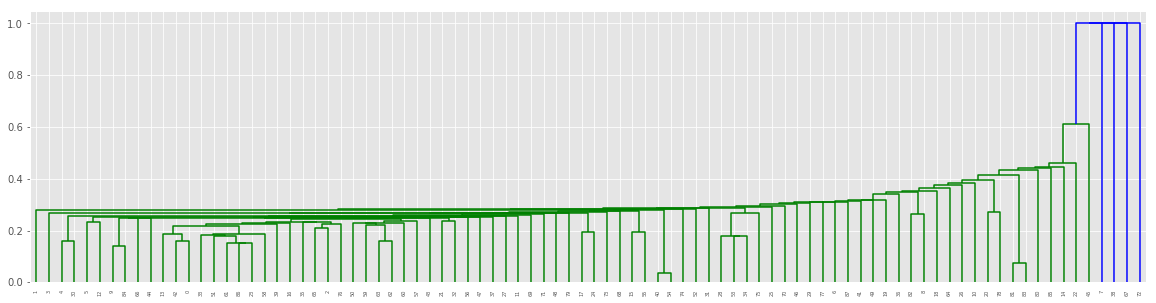

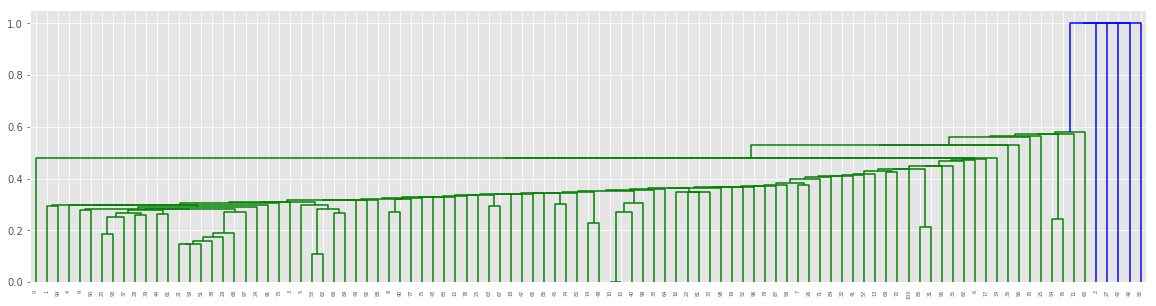

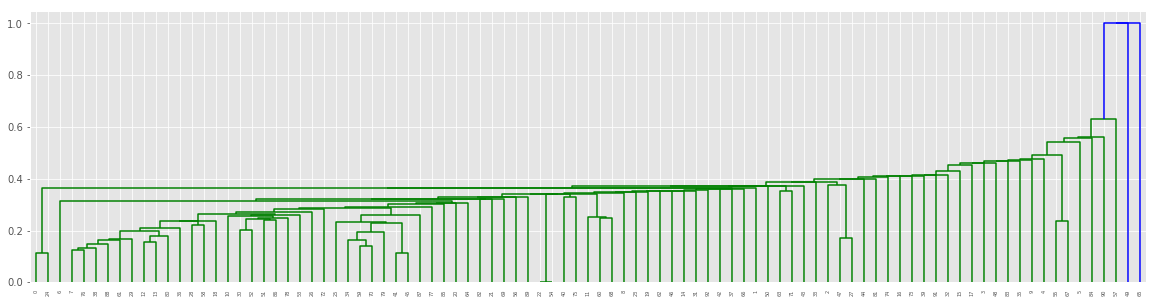

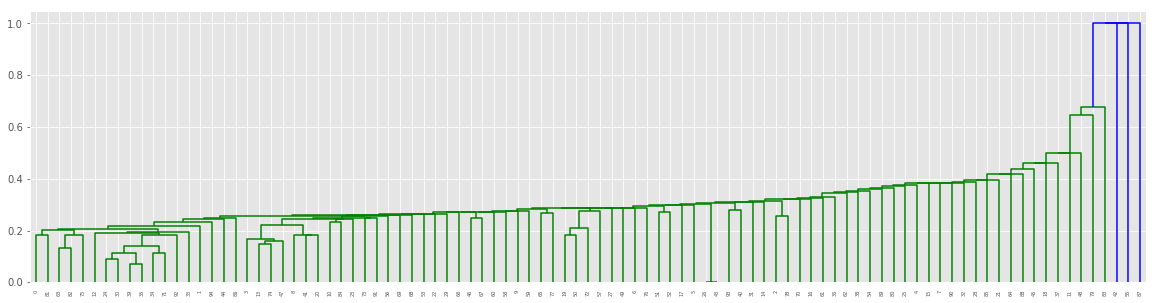

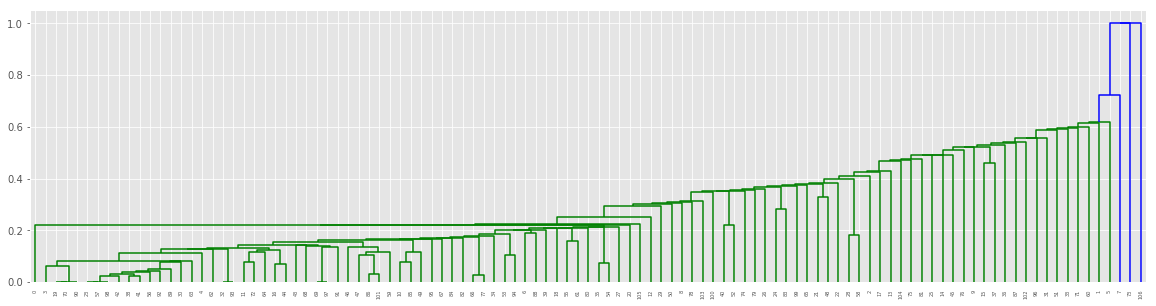

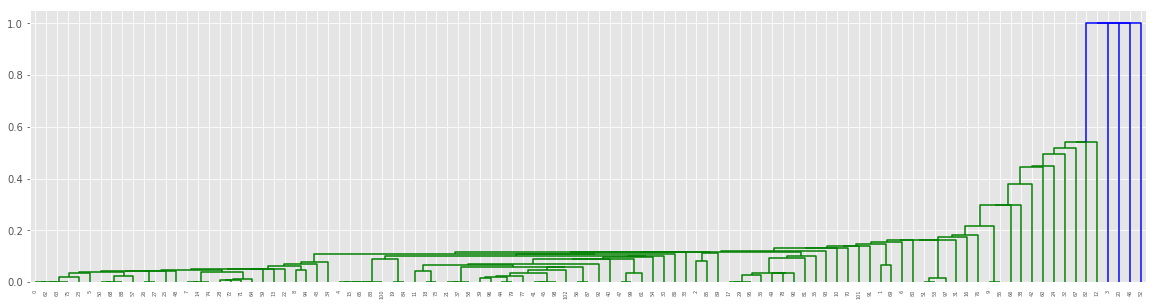

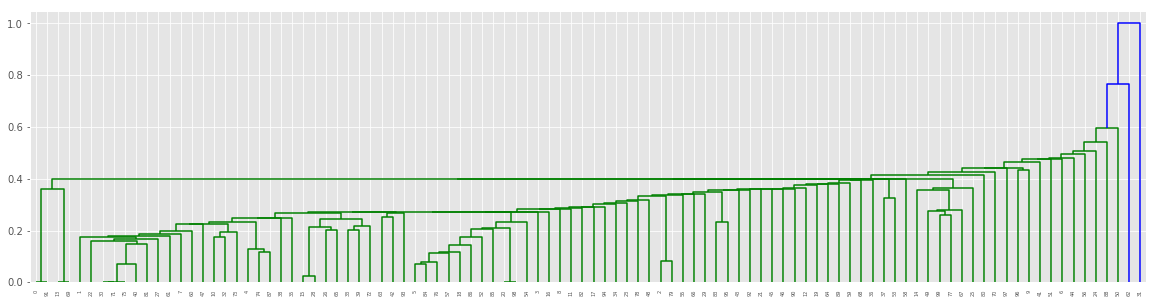

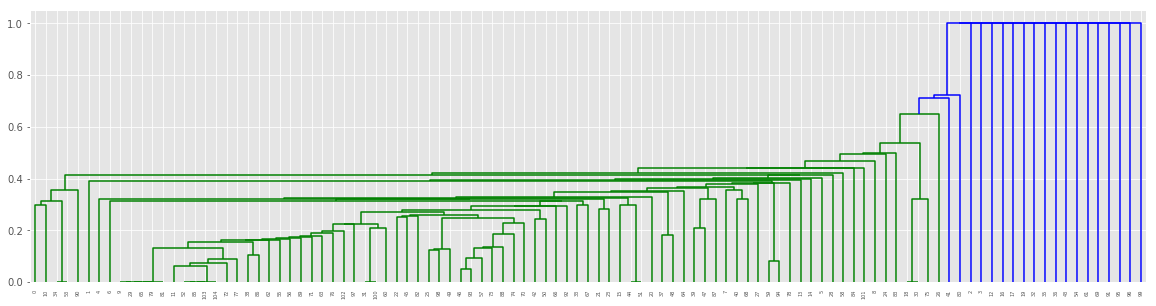

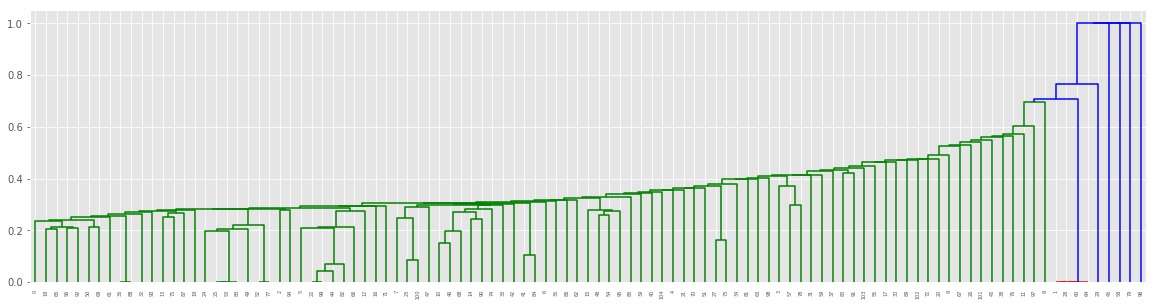

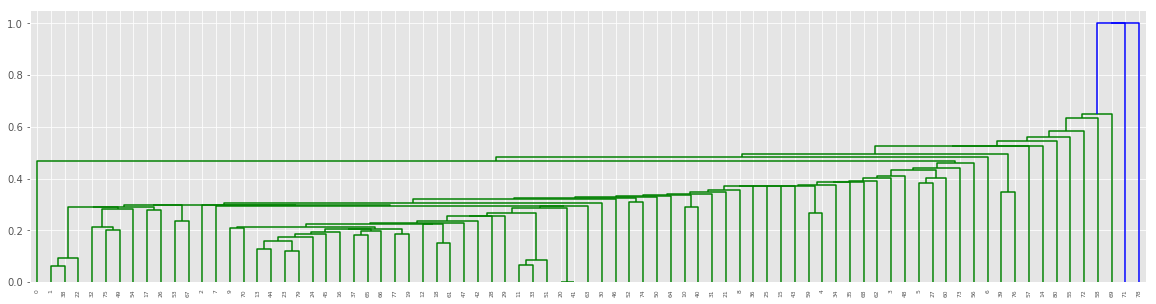

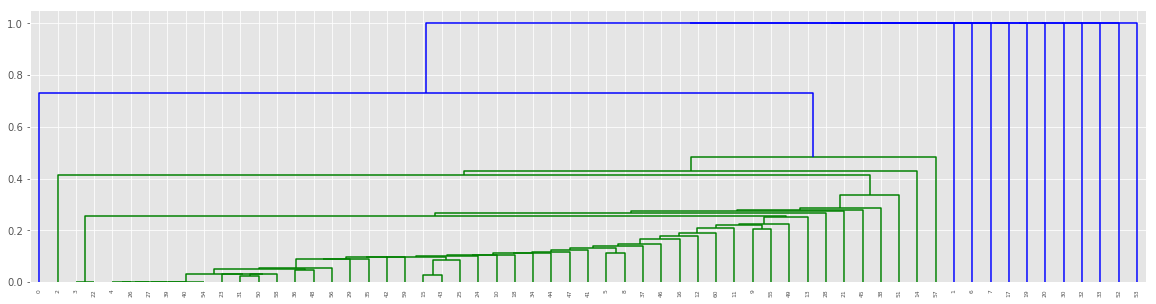

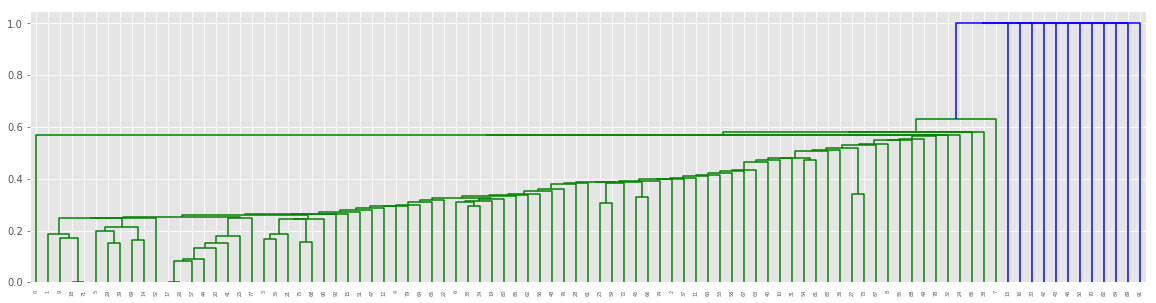

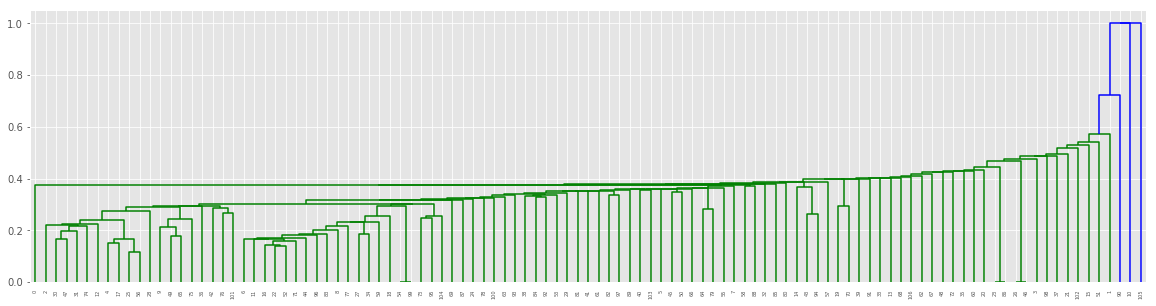

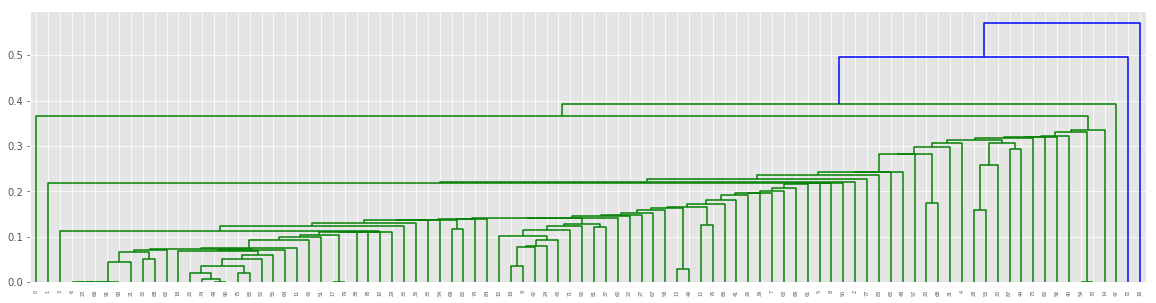

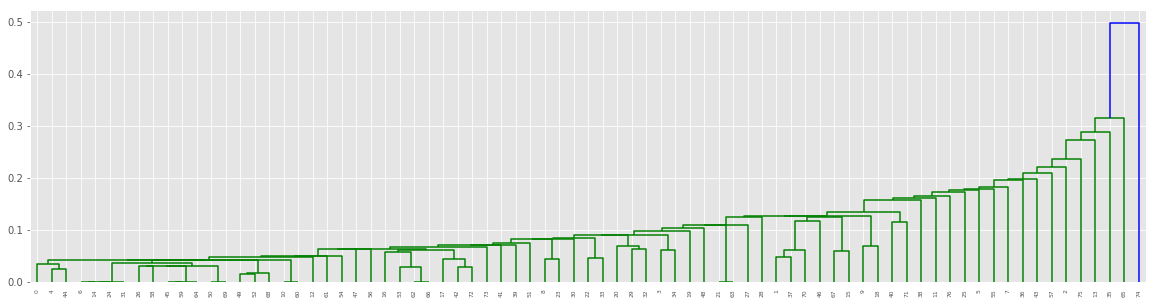

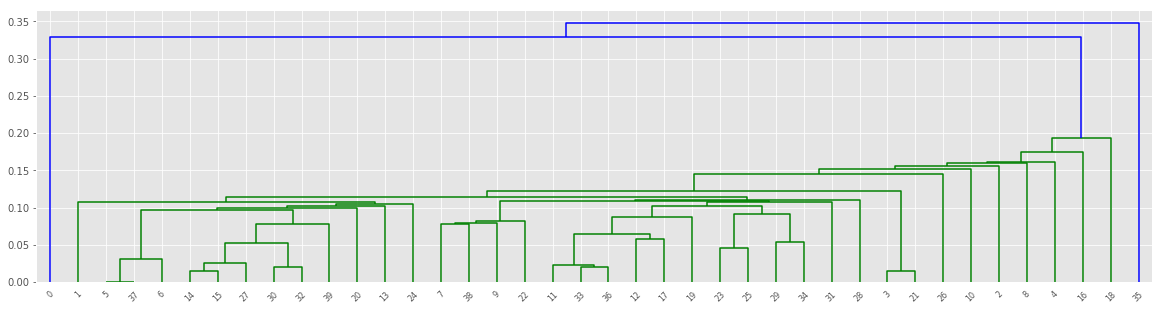

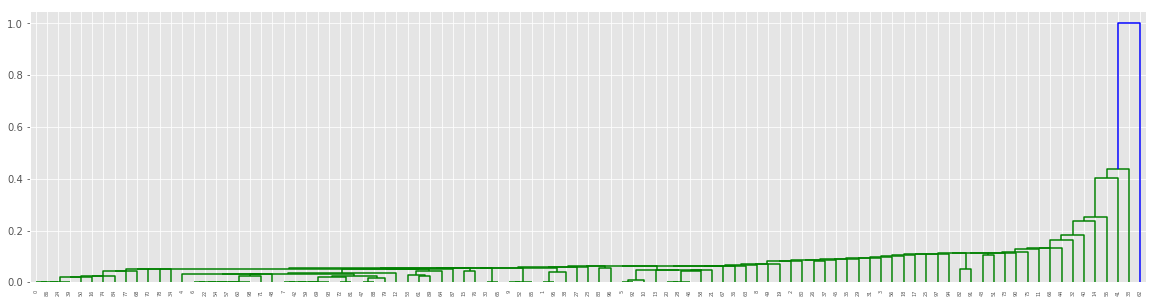

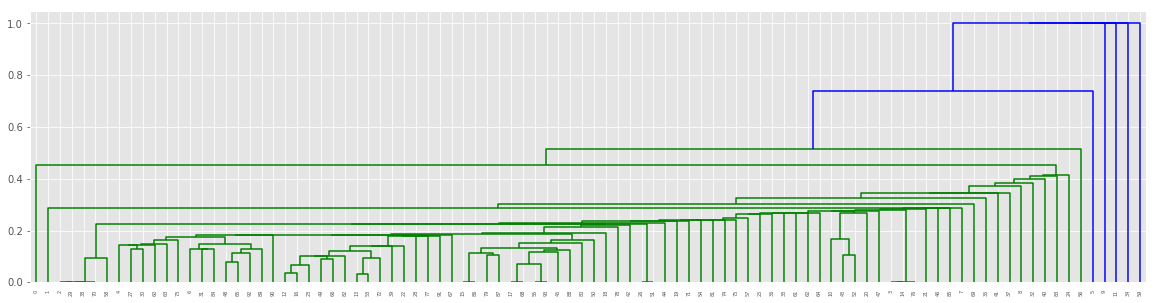

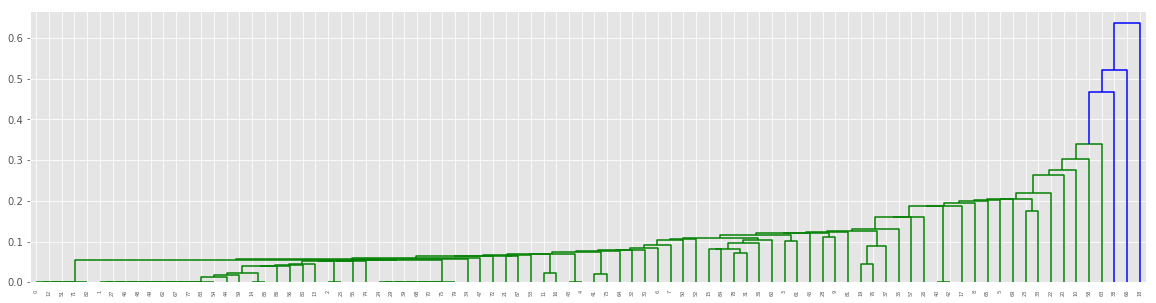

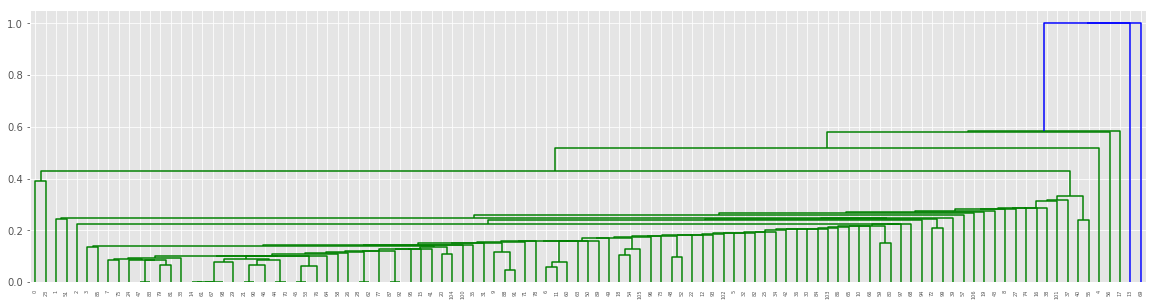

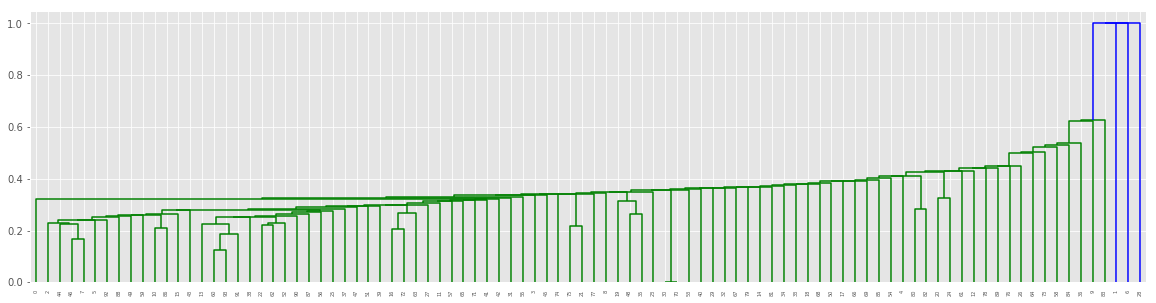

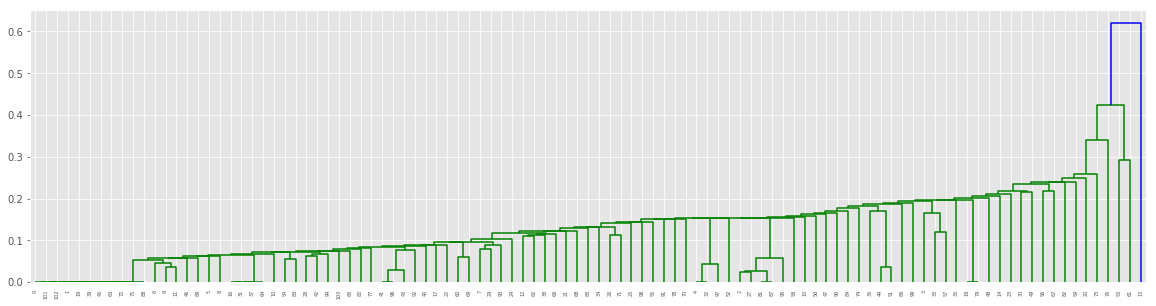

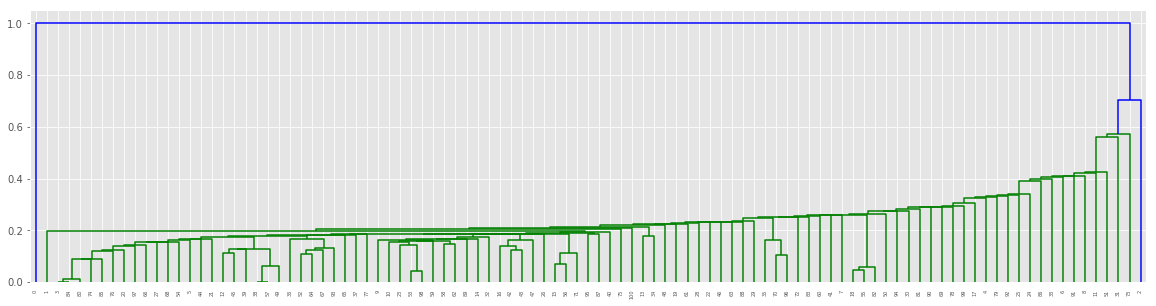

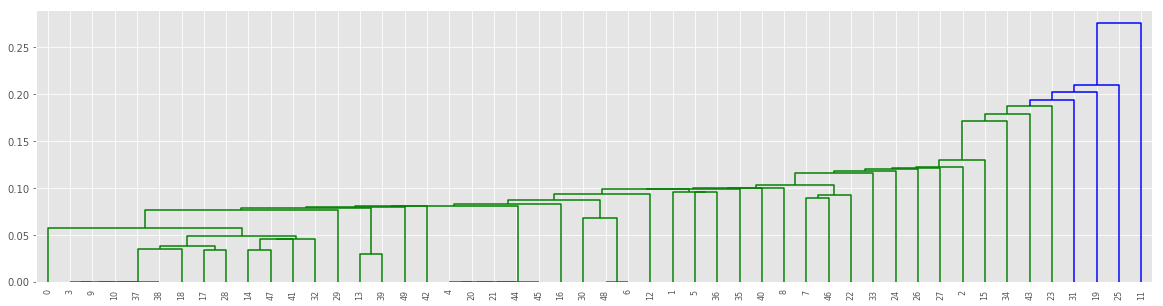

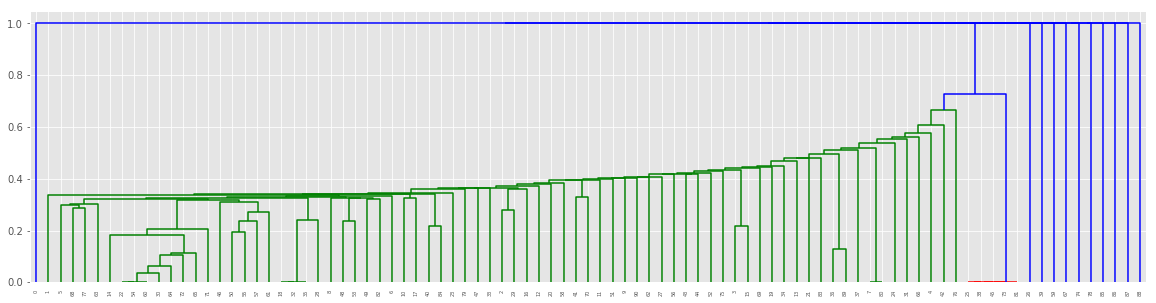

In [59]:
Y_pred = []
Y_test = []
for i in range(1, len(traingroups_titledata) + 1):
    x_train = []
    y1 = []
    for j in range(len(traingroups_titledata[i])):
        y1.append(traingroups_titledata[i][j][2])
        Y_test.append(traingroups_titledata[i][j][2])
#         x_train.append(traingroups_titledata[i][j][1])
        x1 = np.zeros(300)
        n = 0
        for w in traingroups_titledata[i][j][1].split():  
            res = get_word_embedding(w)
            if res is not None:
                x1 += res
                n += 1
        if n:
            x1 /= n
        x_train.append(x1)
#     x_train = tf_idf.fit_transform(x_train)    
#     x_train = x_train.toarray()
    x_train = np.array(x_train)
    y_pred = np.abs(сustum_aggl.fit_predict(x_train) - 1)
    сustum_aggl.plot_dendrogram()
    Y_pred += y_pred.tolist()
#     print(i, f1_score(y1, y_pred))
print(f1_score(Y_pred, Y_test))      

**1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?**

В дендонаграмме иногда очень чётко прослеживаются элементы, которые относяться к выбросу, они присоединяются к общему класстеру в последний момент или же имеет довольно большое расстояние до центра.

**2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?**

Я использовал косинусное расстояние, потому что попытался представить ембеддинг заголовков в виде векторов. Использовл для этого предобученную модель w2v. Можно так же использовать tf-idf. А вообще должно хорошо представлять расстояние мера Жаккара. 

**3) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)**

0.44666351798124293

**4) Как можно результат кластеризации затем использовать для финальной модели обучения с учителем?**

Можно добавить выход модели кластеризации к признакам на вход модели обучения с учителем. Также наверное можно попробовать точно определять наиболее вероятные выбросы, но тут встает проблема, что в некоторых группах аномалий больше, чем настоящих обьектов. Можно действовать наоборот и выделять класстера от аномалий, но тогда наверно лучше использовать другую модель кластеризации, например, dbscan.

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

Методы класстеризации подходят для задач нахождения анамолий в данных. Так же в задач без учителя при нахождении меры близости обьектов друг к другу. Может быть пригодны и в задачах semisupervised, когда есть небольшая группа размеченных данных и достаточно много неразмеченных. Тогда таким образом можно доразмечать новые данные, основываясь на старых.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

kmeans простой в реализации, но зависит от начального распределения центров кластеров, также требует жосткого задания количества кластеров с самого начала.

dbscan не требует задания количества кластеров, он находит выбросы и сам выделяет кластеры. Его проблема в том, что иногда трудно подбирать к нему параметры, а также то, что разные кластеры могут иметь разную плотность.

агломеративная кластеризация довольно понятна для реализации, сразу находит кластеры для разного их количества, но при этом требует много ресурсов. И также можно постараться выделять выбросы.

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

Не стоит приминять метод максимального правдоподобия, например, когда функция правдопадобия имеет много локальных максимумов и когда она не ограничена.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

Для начала провел бы нормализацию документов, т.е. произвел лемматизацию над текстами и убрал стоп слова(такие как союзы, предлоги и тд.). Можно выделить вичи с помощью модели word2vec. Далее использовать кластеризацию и для каждого кластера присвоить тег наиболее близкий по косинусной мере для соответсвующих слов(новости, спорт, кулинария, кино и тд.)

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

Можно попытаться увеличить обучающую, размеченную выборку. Например, кластеризовать большую и трейновую выборку, и той части данных, которая попала в кластер с размеченными данными, присвоить такой же таргет. Так можно постепенно, итеративно увеличивать размеченную выборку. И таким образом более точно знать значение отдельного кластера.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***